# Example development notebook for `app_predict`

Related wiki page:  
https://github.com/stharrold/demo/wiki/app_predict

In [5]:
cd /opt/demo

/opt/demo


In [6]:
# Import standard packages.
import os
import sys
import time
# Import installed packages.
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [7]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("demo:", demo.__version__)

Timestamp:
2017-02-26T16:30:43GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
demo: 0.0.0


In [8]:
!py.test -v --pdb

============================= test session starts ==============================
platform linux -- Python 3.5.2, pytest-2.9.2, py-1.4.31, pluggy-0.3.1 -- /opt/conda/bin/python
cachedir: .cache
rootdir: /opt/demo, inifile: 
collected 8 items 

tests/test__init__.py::test__all__ PASSED
tests/test__init__.py::test__version__ PASSED
tests/test_app_template/test_app_template__init__.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test_main PASSED
tests/test_app_template/test_app_template_main.py::test__main__ PASSED
tests/test_app_template/test_template.py::test_prepend_this PASSED
tests/test_utils/test_utils__init__.py::test__all__ PASSED

=========================== 8 passed in 4.94 seconds ===========================


# Development below

## Initialization

### Imports

In [1]:
cd /opt/demo

/opt/demo


In [128]:
# Import standard packages.
import bs4
import collections
import gc
import glob
import io
import os
import pickle
import requests
import shelve
import subprocess
import sys
import textwrap
import time
import warnings
# Import installed packages.
import geopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.cluster as sk_cl
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
# Import local packages.
# datascience version: TODO link to GitHub tag v0.0.1.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [129]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sk.__version__)
print("seaborn:", sns.__version__)
print("demo:", demo.__version__)

Timestamp:
2017-02-26T20:33:54GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.11.1
pandas: 0.18.1
scipy: 0.17.1
sklearn: 0.17.1
seaborn: 0.7.1
demo: 0.0.0


In [130]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=1) # Set random state for reproducibility.

# File paths
path_data_dir = os.path.join(os.path.abspath(os.path.curdir), r'demo/app_predict/data')
path_csv = os.path.join(path_data_dir, r'Risky Dealer Case Study Transactions.csv')

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

In [115]:
print(r"""`df`: Load and format sales transactions.""")
df = pd.read_csv(path_csv)

`df`: Load and format sales transactions.


In [116]:
df.head()

BuyerID  SellerID  Mileage                VIN SellingLocation    CarMake  \
0   351757    441081    37055  1FAHP3M27CL374352            CAAI       FORD   
1   351757    442235      248  1G1JE6SB7D4103706            DETA  CHEVROLET   
2   351757    436280    39627  1G1PG5SC4C7102274            CAAI  CHEVROLET   
3   351757    436280    50773  1G1PG5SC5C7113820            CAAI  CHEVROLET   
4   351757    434202    54133  1GNKVGED4BJ301146            SVAA  CHEVROLET   

   SalePrice  CarYear    MMR  JDPowersCat    ...     Salvage  OVE  Simulcast  \
0      13000     2012  13050  COMPACT CAR    ...           0    0          0   
1      13900     2013  13600  COMPACT CAR    ...           0    0          0   
2      13800     2012  14050  MIDSIZE CAR    ...           0    0          0   
3      12900     2012  13150  MIDSIZE CAR    ...           0    0          0   
4      17800     2011  18050          SUV    ...           0    0          0   

   InLane  PSIEligible  SaleDate  Autocheck_score  ConditionReport  \
0       0            1  13-07-25         1.000000              NaN   
1       0            1  13-10-24              NaN              NaN   
2       1            1  13-04-18        -2.666667               41   
3       1            1  13-04-18         1.000000               31   
4       1            1  13-02-26        -1.400000               34   

   DSEligible  Returned  
0           1       0.0  
1           1       NaN  
2           1       NaN  
3           1       NaN  
4           1       NaN  

[5 rows x 25 columns]

In [117]:
df_backup = df.copy()

In [118]:
# df = df_backup.copy()

In [119]:
df = demo.app_predict.predict.eta(df=df, path_data_dir=path_data_dir)
gc.collect()

################################################################################
DSEligible, Returned: Fix DSEligible == 0 but Returned not null.
To correct: If Returned not null, then DSEligible = 1.

Before:
Returned        0.0     1.0       nan       All
DSEligible                                     
0             542.0   291.0   15343.0   16176.0
1           14984.0  3876.0  243301.0  262161.0
All         15526.0  4167.0  258644.0  278337.0

After:
Returned        0.0     1.0       nan       All
DSEligible                                     
0               NaN     NaN   15343.0   15343.0
1           15526.0  4167.0  243301.0  262994.0
All         15526.0  4167.0  258644.0  278337.0

################################################################################
Returned: Fill nulls with -1 and cast to int.

Before:
Returned        0.0     1.0       nan       All
DSEligible                                     
0               NaN     NaN   15343.0   15343.0
1           15526.0  

128306

In [120]:
df.dtypes[0:20]

BuyerID            object
SellerID           object
Mileage             int64
VIN                object
SellingLocation    object
CarMake            object
SalePrice           int64
CarYear             int64
MMR                 int64
JDPowersCat        object
LIGHTG              int64
LIGHTY              int64
LIGHTR              int64
PSI                 int64
Arbitrated          int64
Salvage             int64
OVE                 int64
Simulcast           int64
InLane              int64
PSIEligible         int64
dtype: object

In [121]:
df.dtypes[20:40]

SaleDate                   datetime64[ns]
Autocheck_score                   float64
ConditionReport                     int64
DSEligible                          int64
Returned                            int64
Returned_asm                        int64
SellingLocation_lat               float64
SellingLocation_lon               float64
JDPowersCat_COMPACTCAR            float64
JDPowersCat_EXCLUDED              float64
JDPowersCat_FULLSIZECAR           float64
JDPowersCat_LUXURYCAR             float64
JDPowersCat_MIDSIZECAR            float64
JDPowersCat_PICKUP                float64
JDPowersCat_SPORTSCAR             float64
JDPowersCat_SUV                   float64
JDPowersCat_UNKNOWN               float64
JDPowersCat_VAN                   float64
LIGHT_N0G1Y2R3                      int64
SaleDate_dow                        int64
dtype: object

In [122]:
df.dtypes[40:60]

SaleDate_doy                                    int64
SaleDate_day                                    int64
SaleDate_decyear                              float64
BuyerID_numTransactions                         int64
BuyerID_numDSEligible1                          int64
BuyerID_fracDSEligible1DivTransactions        float64
BuyerID_numReturnedNotNull                    float64
BuyerID_fracReturnedNotNullDivDSEligible1     float64
BuyerID_numReturned1                          float64
BuyerID_fracReturned1DivReturnedNotNull       float64
BuyerID_numReturnedasm1                       float64
BuyerID_fracReturnedasm1DivTransactions       float64
SellerID_numTransactions                        int64
SellerID_numDSEligible1                       float64
SellerID_fracDSEligible1DivTransactions       float64
SellerID_numReturnedNotNull                   float64
SellerID_fracReturnedNotNullDivDSEligible1    float64
SellerID_numReturned1                         float64
SellerID_fracReturned1DivRet

In [123]:
df.dtypes[60:80]

SellerID_fracReturnedasm1DivTransactions             float64
VIN_numTransactions                                    int64
VIN_numDSEligible1                                   float64
VIN_fracDSEligible1DivTransactions                   float64
VIN_numReturnedNotNull                               float64
VIN_fracReturnedNotNullDivDSEligible1                float64
VIN_numReturned1                                     float64
VIN_fracReturned1DivReturnedNotNull                  float64
VIN_numReturnedasm1                                  float64
VIN_fracReturnedasm1DivTransactions                  float64
SellingLocation_numTransactions                        int64
SellingLocation_numDSEligible1                         int64
SellingLocation_fracDSEligible1DivTransactions       float64
SellingLocation_numReturnedNotNull                   float64
SellingLocation_fracReturnedNotNullDivDSEligible1    float64
SellingLocation_numReturned1                         float64
SellingLocation_fracRetu

In [124]:
df.dtypes[80:100]

CarMake_numDSEligible1                           float64
CarMake_fracDSEligible1DivTransactions           float64
CarMake_numReturnedNotNull                       float64
CarMake_fracReturnedNotNullDivDSEligible1        float64
CarMake_numReturned1                             float64
CarMake_fracReturned1DivReturnedNotNull          float64
CarMake_numReturnedasm1                          float64
CarMake_fracReturnedasm1DivTransactions          float64
JDPowersCat_numTransactions                        int64
JDPowersCat_numDSEligible1                         int64
JDPowersCat_fracDSEligible1DivTransactions       float64
JDPowersCat_numReturnedNotNull                     int64
JDPowersCat_fracReturnedNotNullDivDSEligible1    float64
JDPowersCat_numReturned1                           int64
JDPowersCat_fracReturned1DivReturnedNotNull      float64
JDPowersCat_numReturnedasm1                        int64
JDPowersCat_fracReturnedasm1DivTransactions      float64
dtype: object

## Exploratory data analysis

In [125]:
# Define features
ftrs = df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')]

In [126]:
# Describe features
df[ftrs].describe(include='all')

Mileage      SalePrice        CarYear            MMR  \
count  278337.000000  278337.000000  278337.000000  278337.000000   
mean    84228.544933   11973.232032    2007.407140   11388.524882   
std     54879.931708    9083.860494       3.956124    9025.527367   
min         1.000000       1.000000    1936.000000       0.000000   
25%     38778.000000    5600.000000    2005.000000    4775.000000   
50%     79599.000000   10100.000000    2008.000000    9700.000000   
75%    114088.000000   16000.000000    2011.000000   15750.000000   
max    999999.000000  355000.000000    2014.000000  172000.000000   

              LIGHTG         LIGHTY         LIGHTR            PSI  \
count  278337.000000  278337.000000  278337.000000  278337.000000   
mean        0.267977       0.042592       0.217998       0.306650   
std         0.442907       0.201936       0.412887       0.461104   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Arbitrated        Salvage  \
count  278337.000000  278337.000000   
mean        0.071316       0.037555   
std         0.257353       0.190118   
min         0.000000       0.000000   
25%         0.000000       0.000000   
50%         0.000000       0.000000   
75%         0.000000       0.000000   
max         1.000000       1.000000   

                          ...                       \
count                     ...                        
mean                      ...                        
std                       ...                        
min                       ...                        
25%                       ...                        
50%                       ...                        
75%                       ...                        
max                       ...                        

       CarMake_fracReturnedasm1DivTransactions  JDPowersCat_numTransactions  \
count                            278337.000000                278337.000000   
mean                                  0.070095                 53370.273823   
std                                   0.031658                 25265.257670   
min                                   0.000000                   356.000000   
25%                                   0.057439                 34850.000000   
50%                                   0.071465                 61532.000000   
75%                                   0.076672                 84831.000000   
max                                   1.000000                 84831.000000   

       JDPowersCat_numDSEligible1  JDPowersCat_fracDSEligible1DivTransactions  \
count               278337.000000                               278337.000000   
mean                 50731.510123                                    0.944876   
std                  24447.790690                                    0.019648   
min                    236.000000                                    0.662921   
25%                  33018.000000                                    0.939576   
50%                  57814.000000                                    0.945218   
75%                  81571.000000                                    0.961571   
max                  81571.000000                                    0.961571   

       JDPowersCat_numReturnedNotNull  \
count                   278337.000000   
mean                      3810.885825   
std                       1843.951429   
min                          4.000000   
25%                       2474.000000   
50%                       4271.000000   
75%                       6165.000000   
max                       6165.000000   

       JDPowersCat_fracReturnedNotNullDivDSEligible1  \
count                                  278337.000000   
mean  

################################################################################
Feature: Mileage


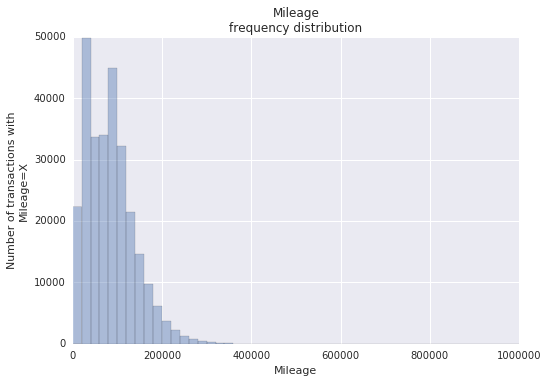

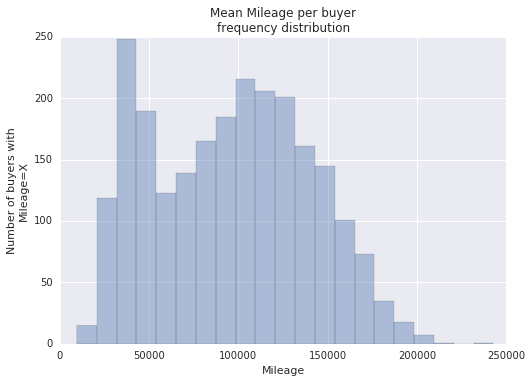

################################################################################
Feature: SalePrice


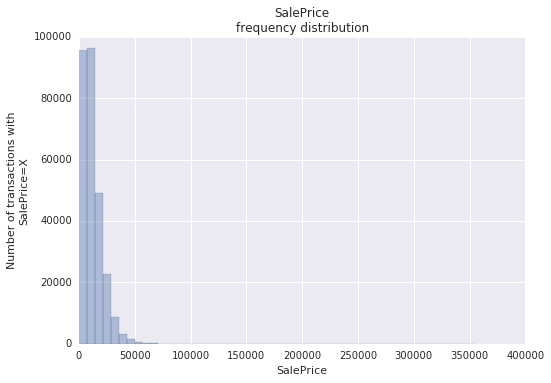

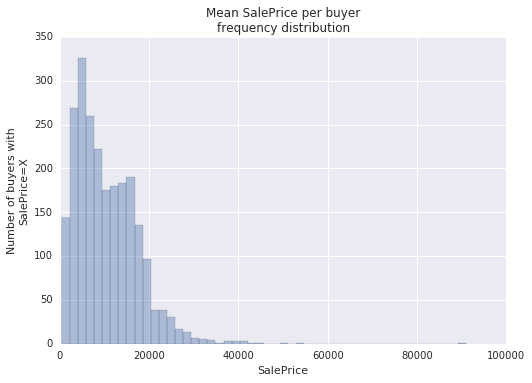

################################################################################
Feature: CarYear


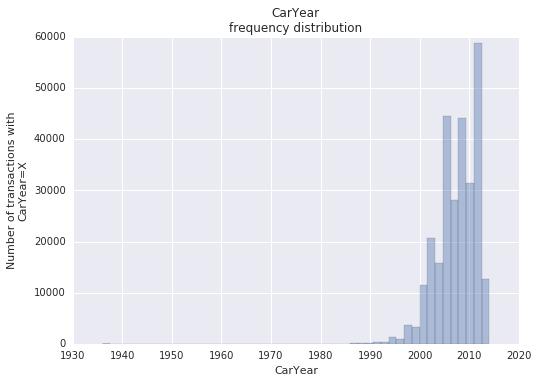

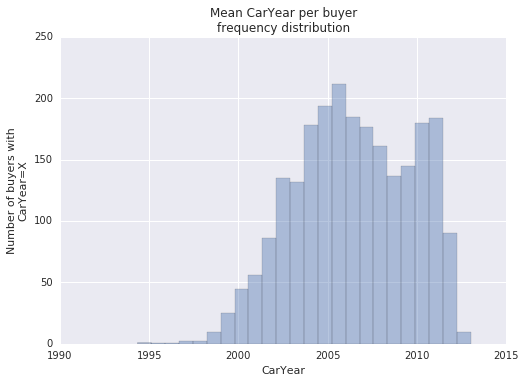

################################################################################
Feature: MMR


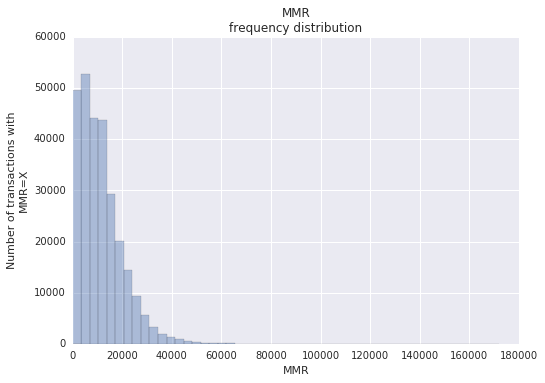

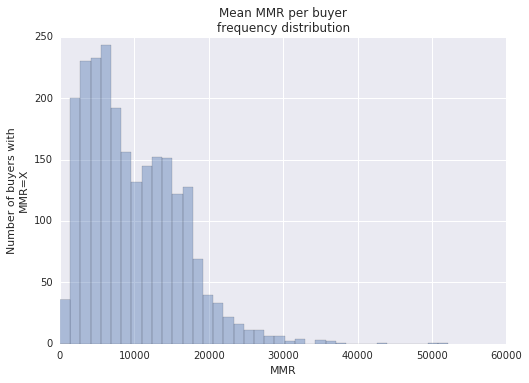

################################################################################
Feature: LIGHTG


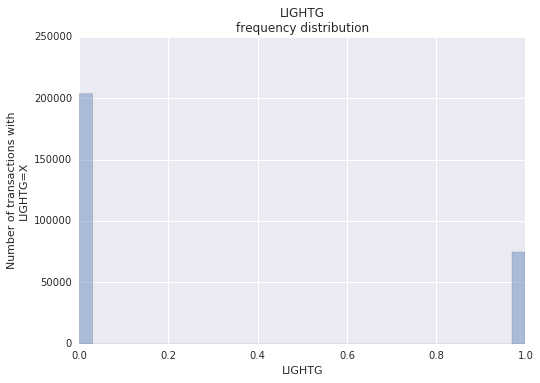

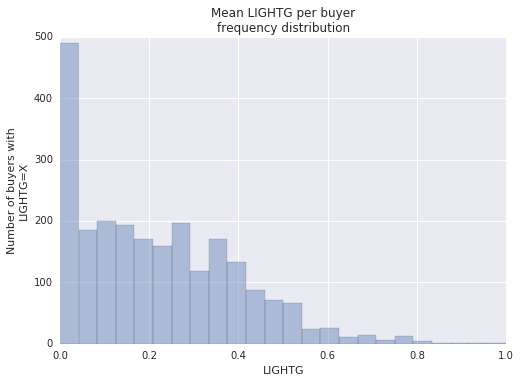

################################################################################
Feature: LIGHTY


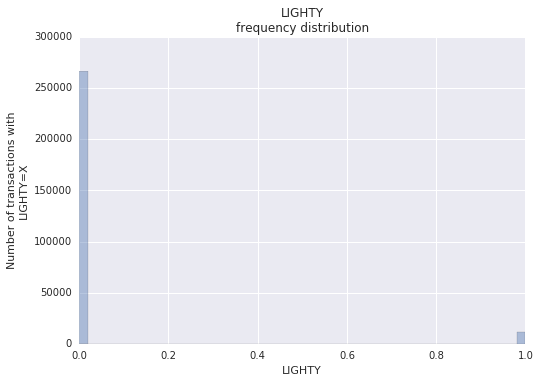

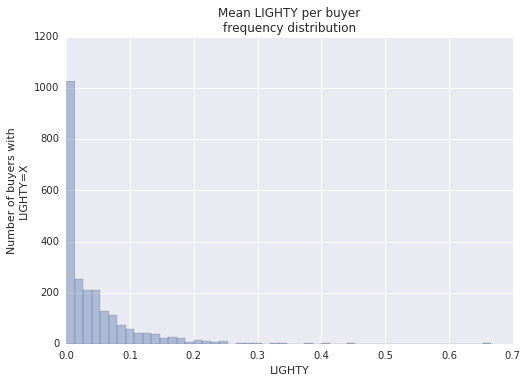

################################################################################
Feature: LIGHTR


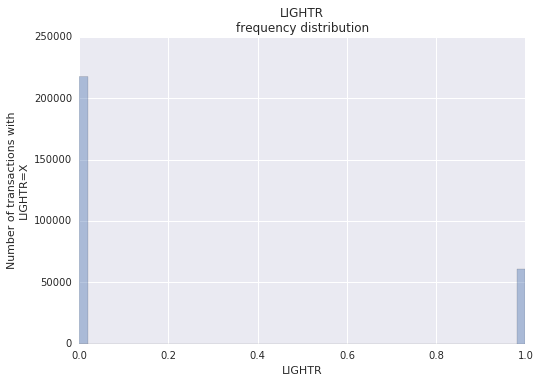

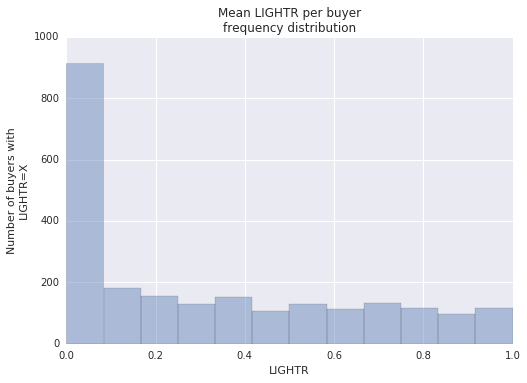

################################################################################
Feature: PSI


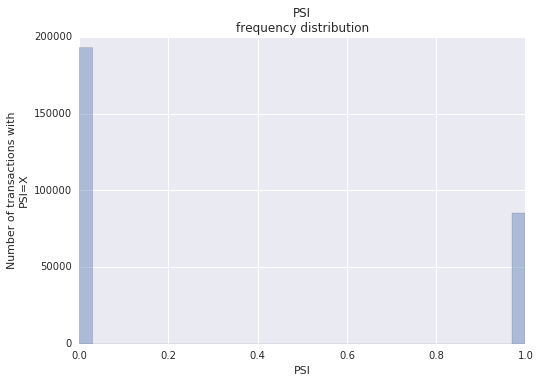

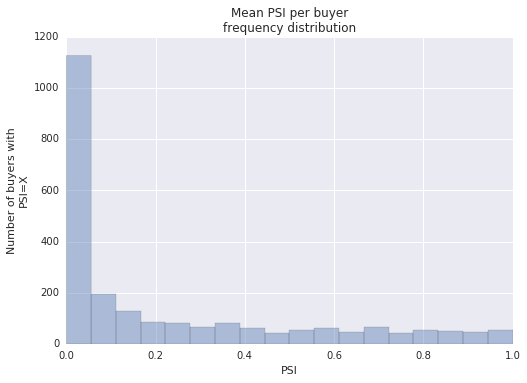

################################################################################
Feature: Arbitrated


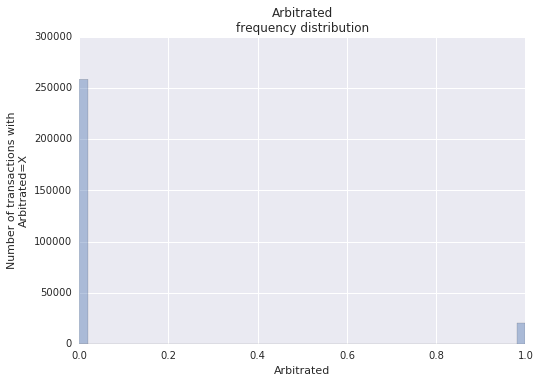

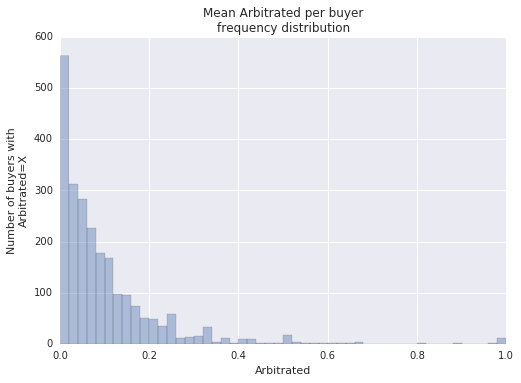

################################################################################
Feature: Salvage


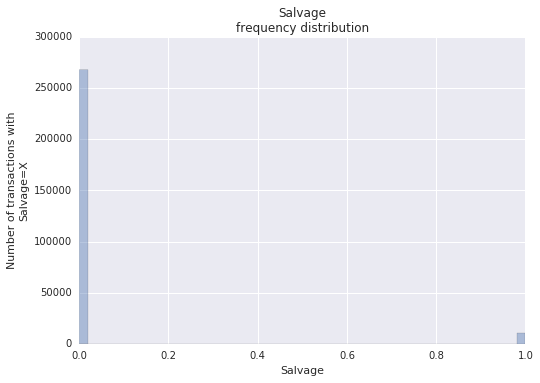

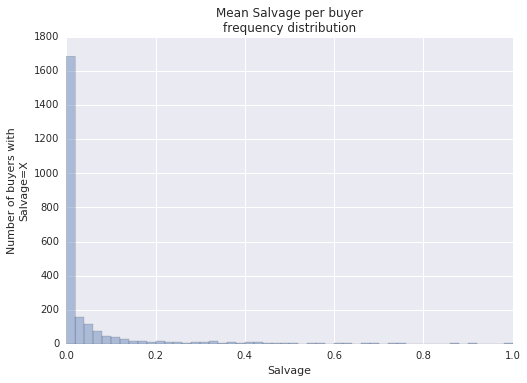

################################################################################
Feature: OVE


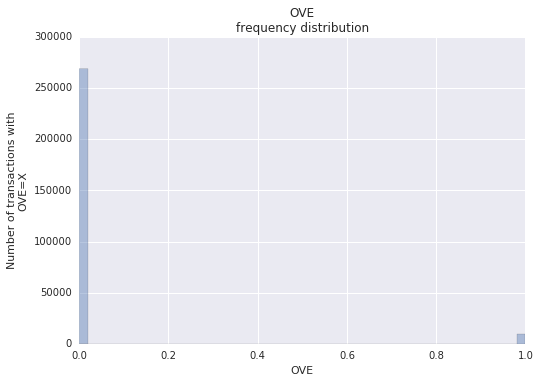

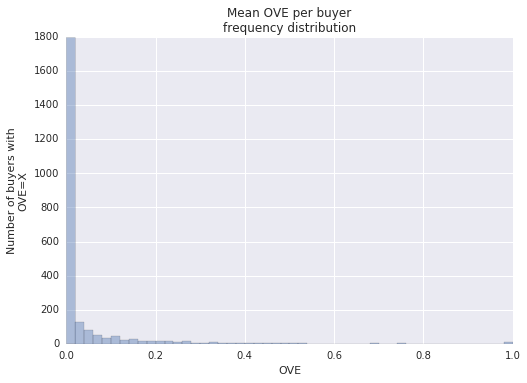

################################################################################
Feature: Simulcast


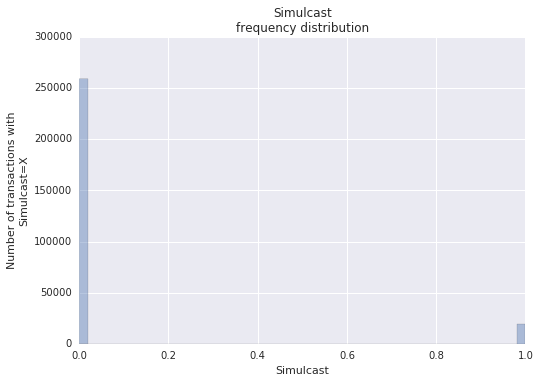

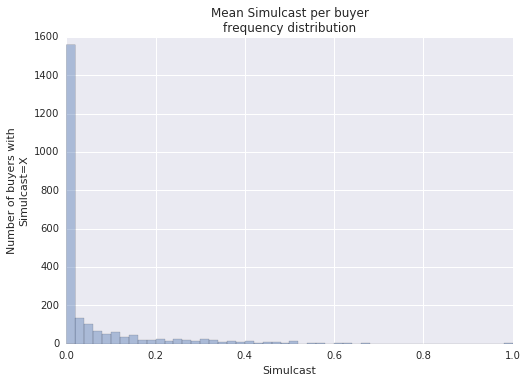

################################################################################
Feature: InLane


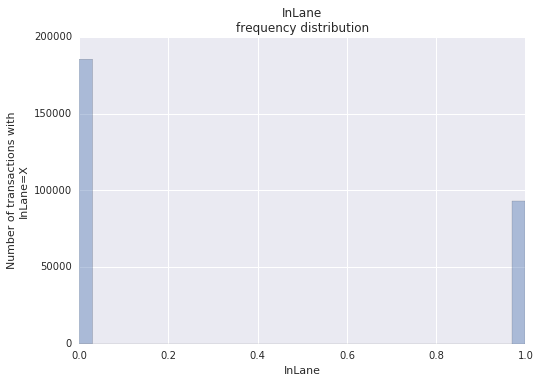

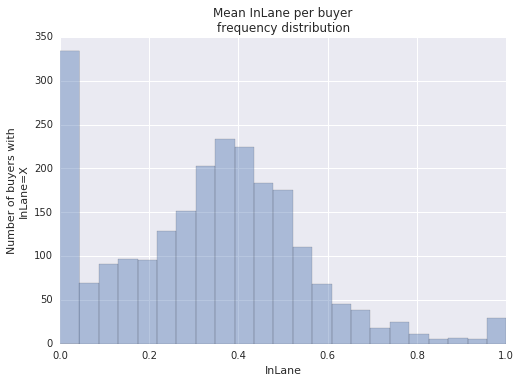

################################################################################
Feature: PSIEligible


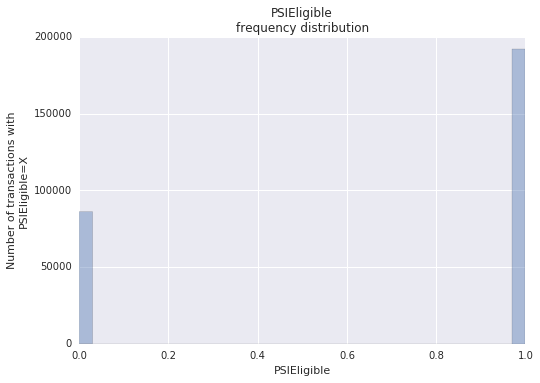

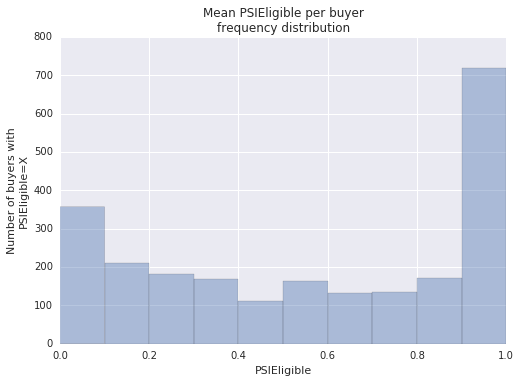

################################################################################
Feature: Autocheck_score


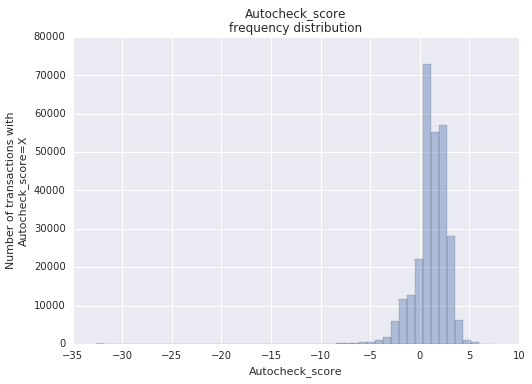

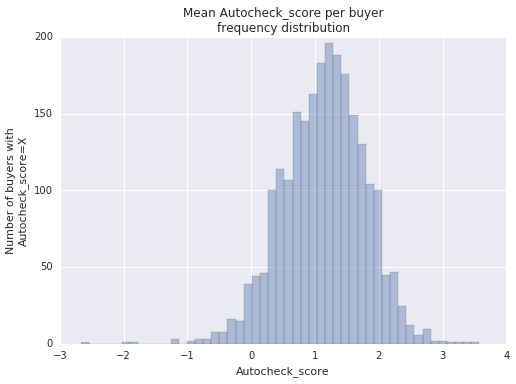

################################################################################
Feature: ConditionReport


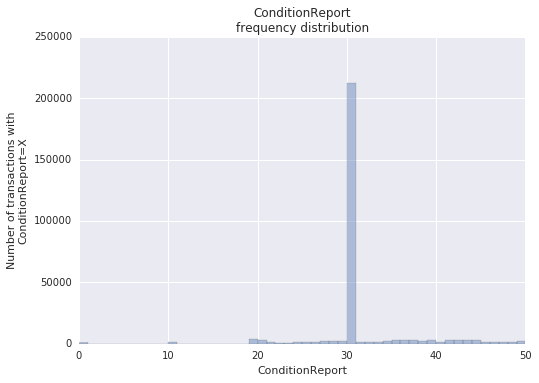

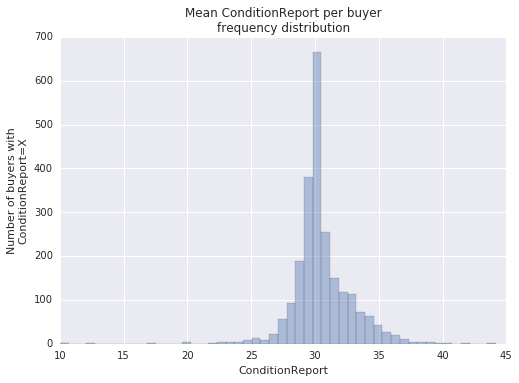

################################################################################
Feature: DSEligible


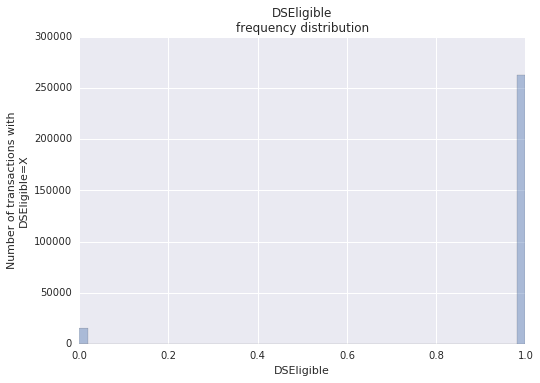

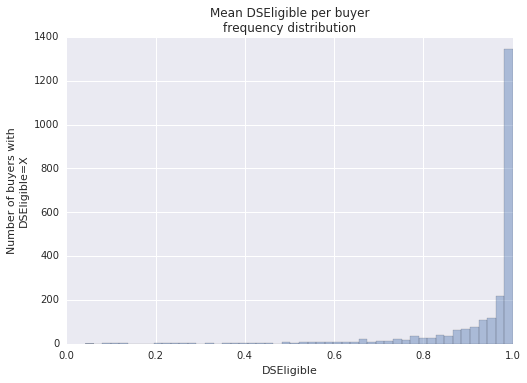

################################################################################
Feature: Returned


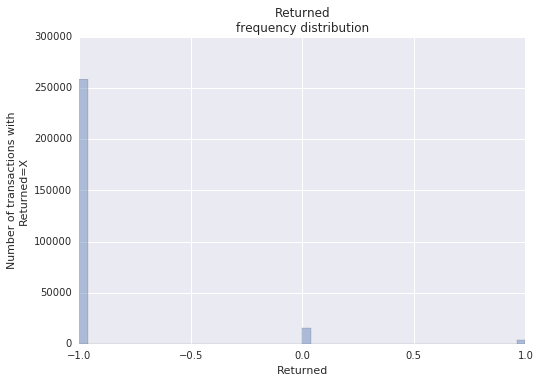

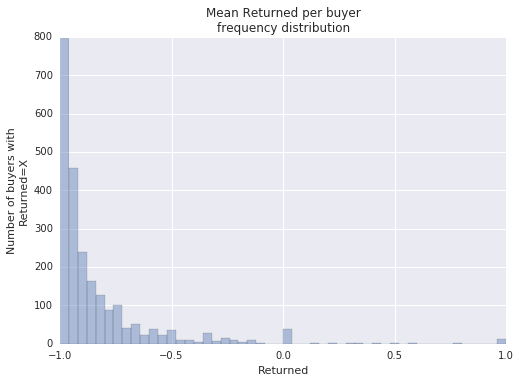

################################################################################
Feature: Returned_asm


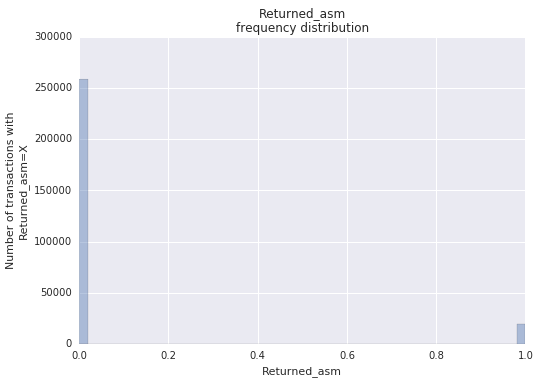

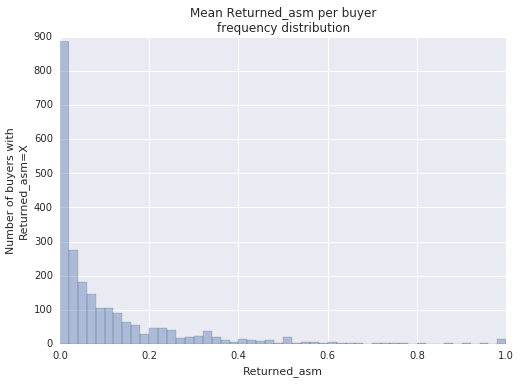

################################################################################
Feature: SellingLocation_lat


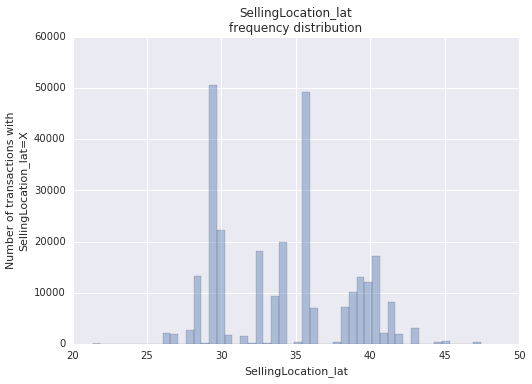

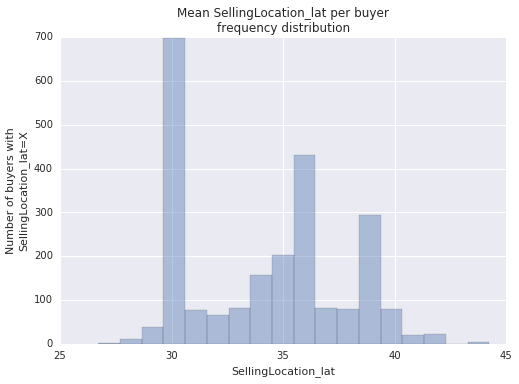

################################################################################
Feature: SellingLocation_lon


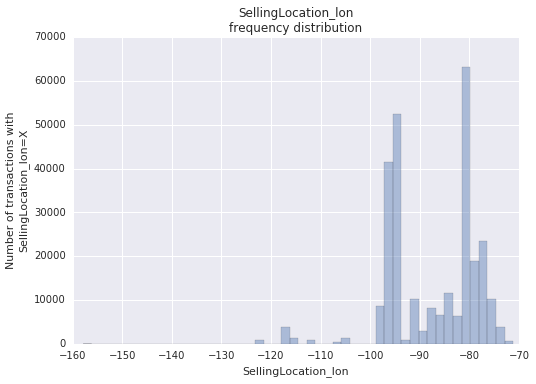

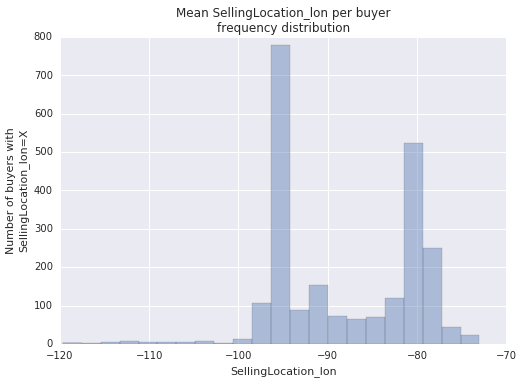

################################################################################
Feature: JDPowersCat_COMPACTCAR


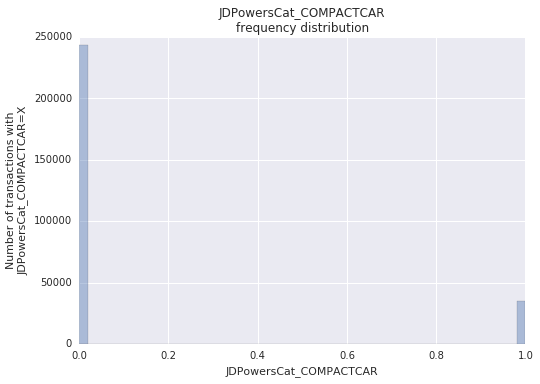

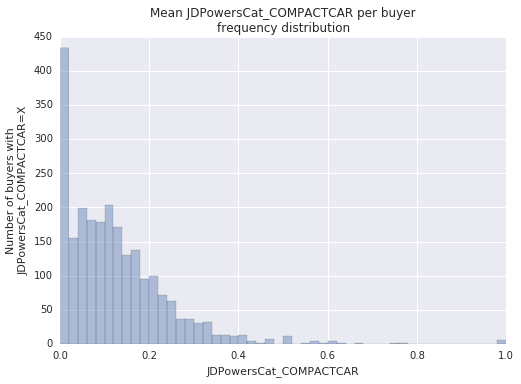

################################################################################
Feature: JDPowersCat_EXCLUDED


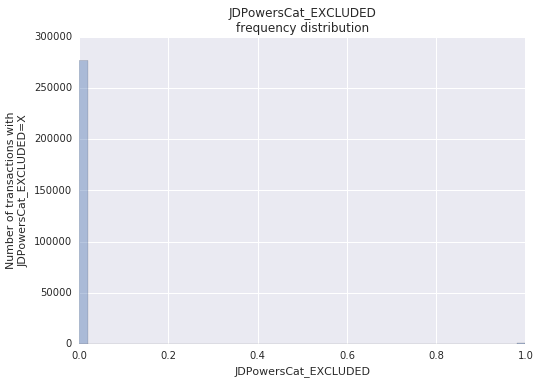

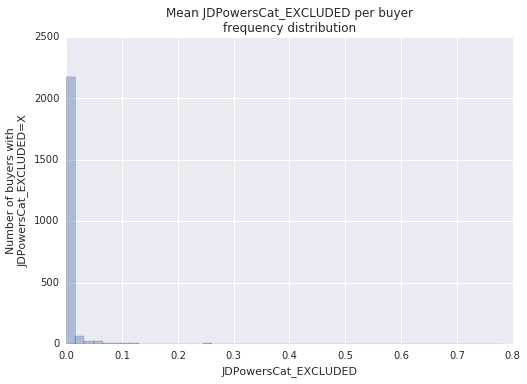

################################################################################
Feature: JDPowersCat_FULLSIZECAR


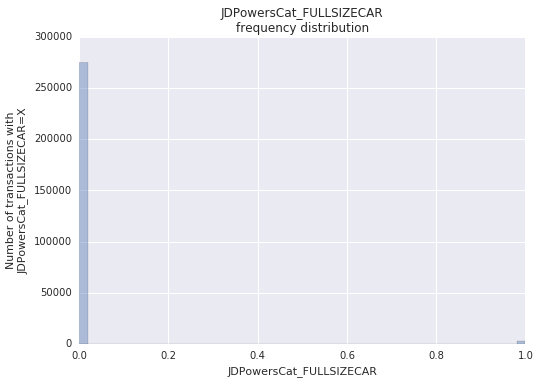

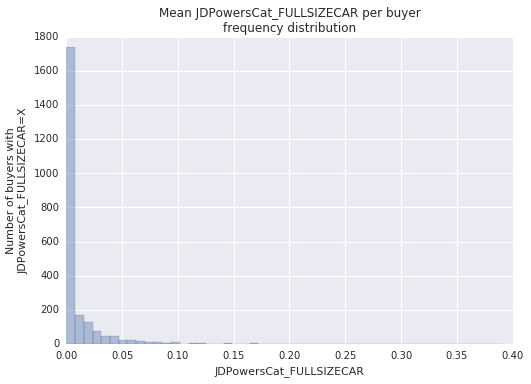

################################################################################
Feature: JDPowersCat_LUXURYCAR


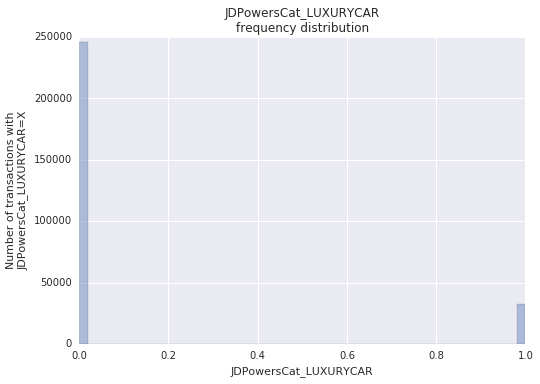

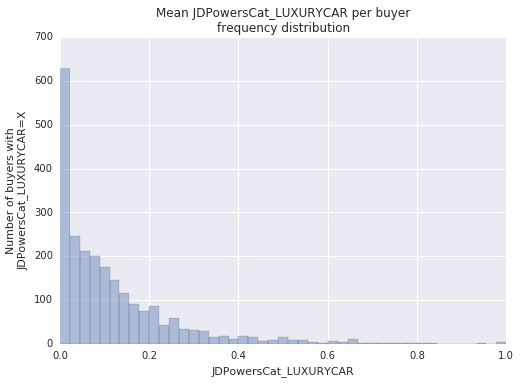

################################################################################
Feature: JDPowersCat_MIDSIZECAR


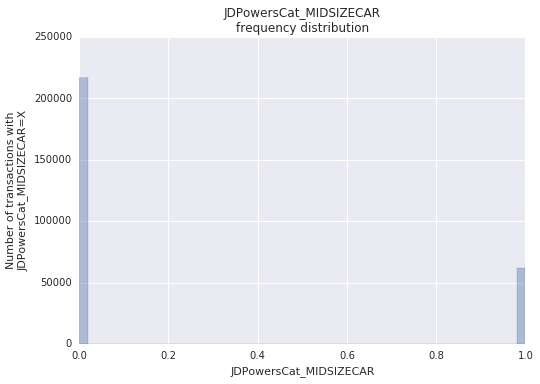

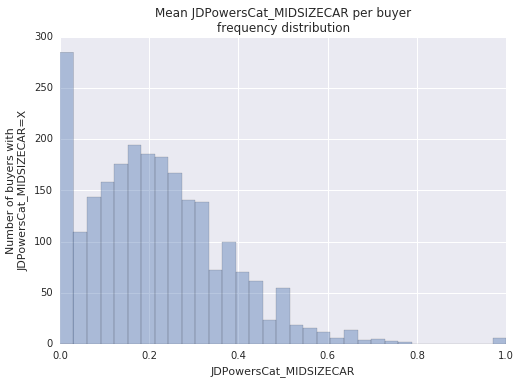

################################################################################
Feature: JDPowersCat_PICKUP


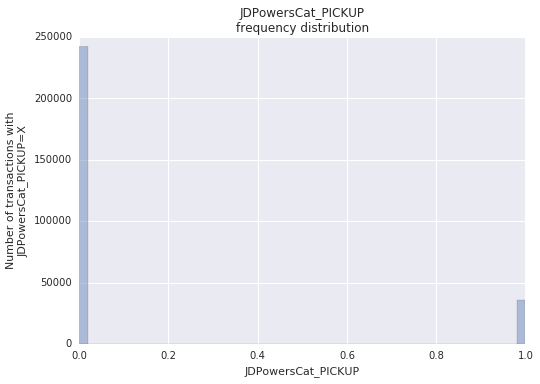

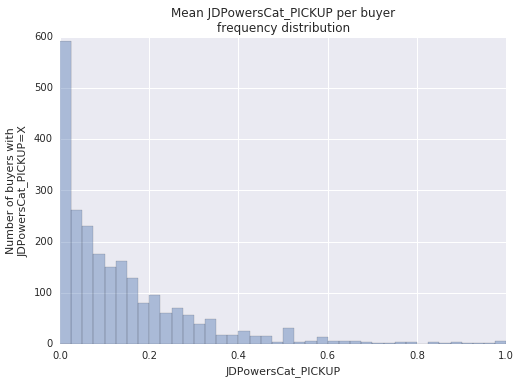

################################################################################
Feature: JDPowersCat_SPORTSCAR


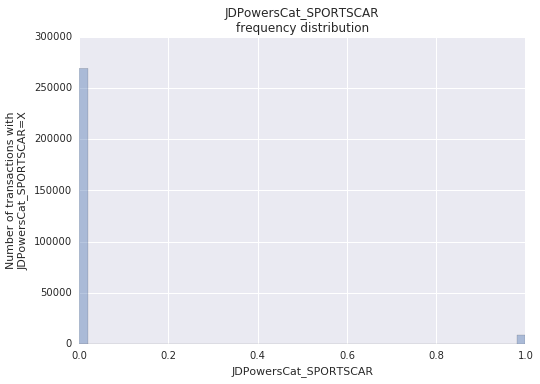

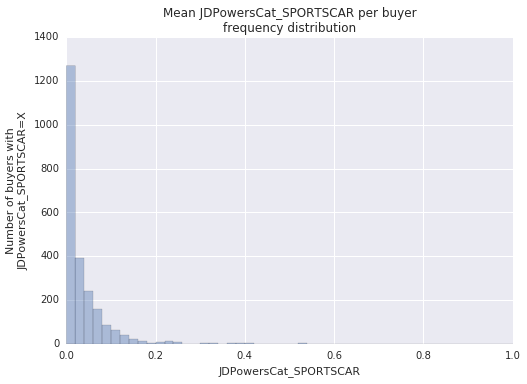

################################################################################
Feature: JDPowersCat_SUV


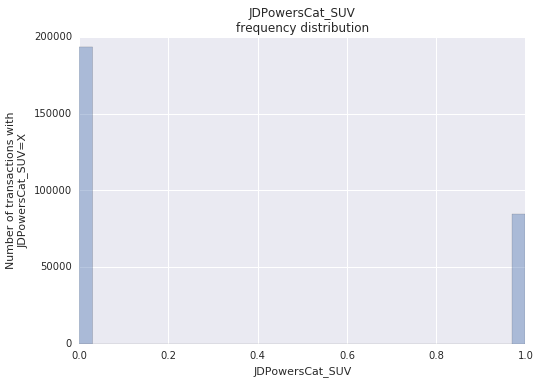

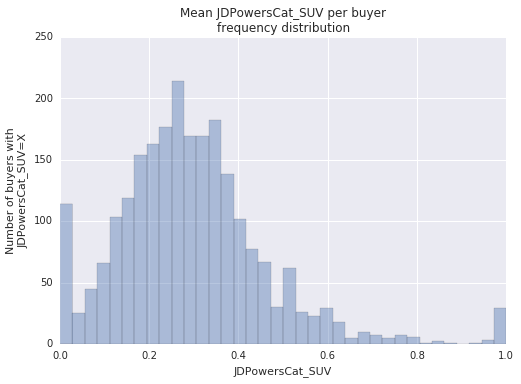

################################################################################
Feature: JDPowersCat_UNKNOWN


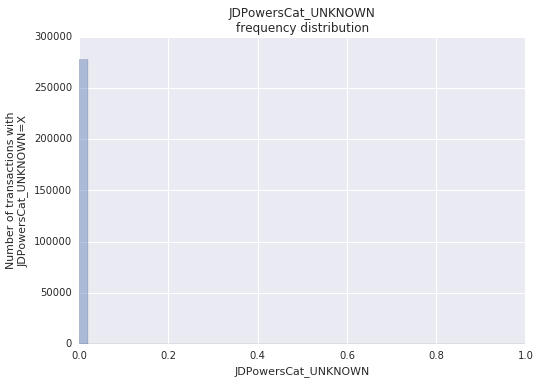

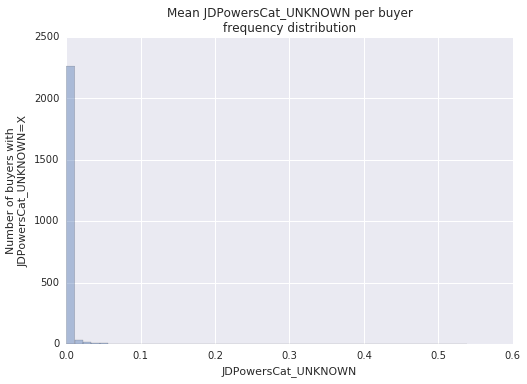

################################################################################
Feature: JDPowersCat_VAN


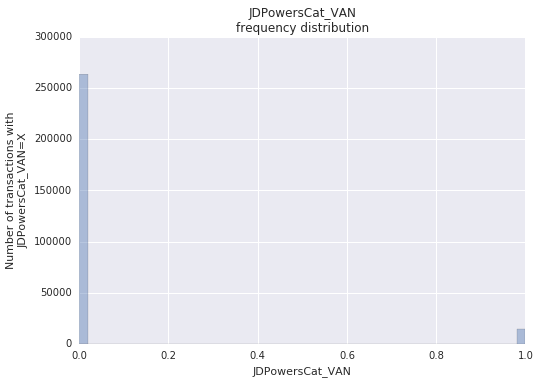

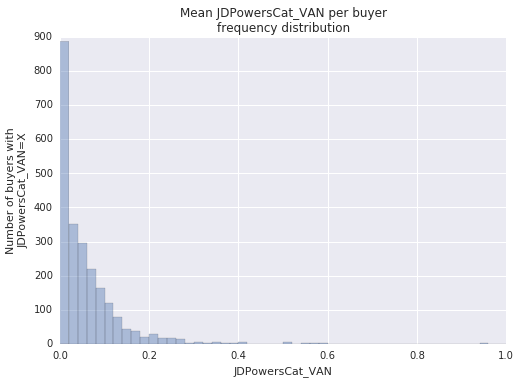

################################################################################
Feature: LIGHT_N0G1Y2R3


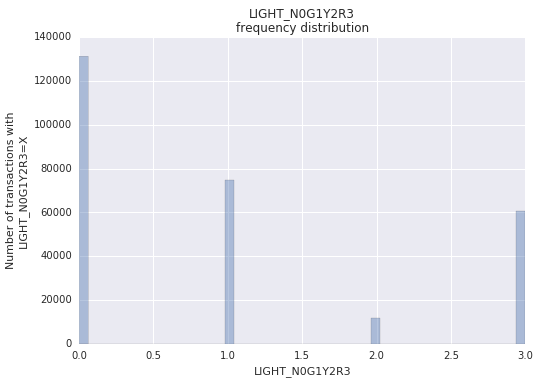

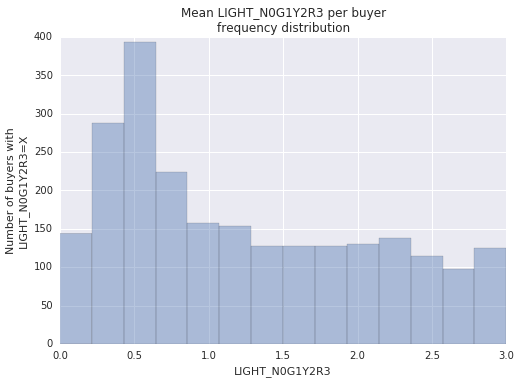

################################################################################
Feature: SaleDate_dow


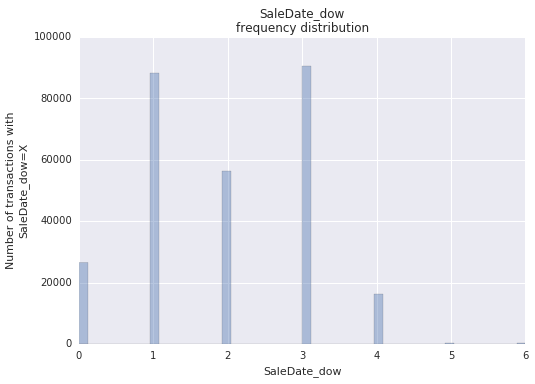

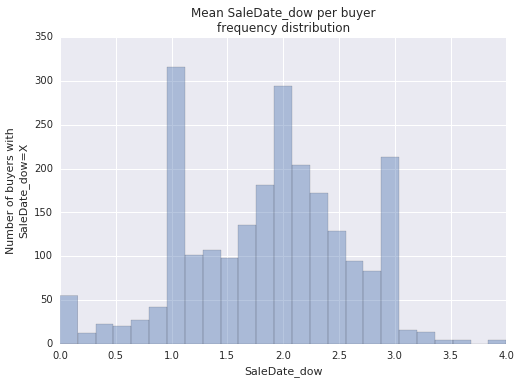

################################################################################
Feature: SaleDate_doy


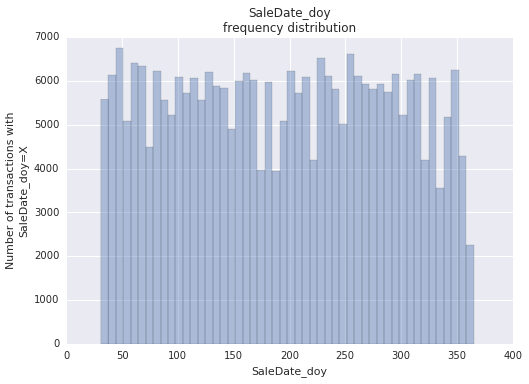

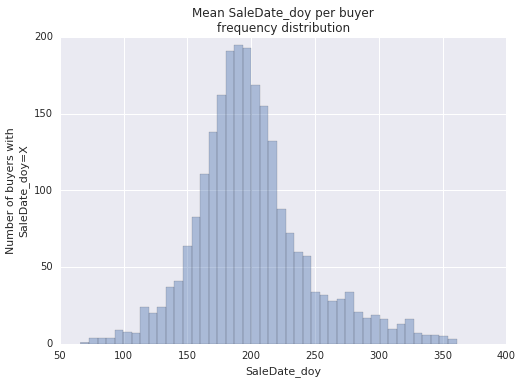

################################################################################
Feature: SaleDate_day


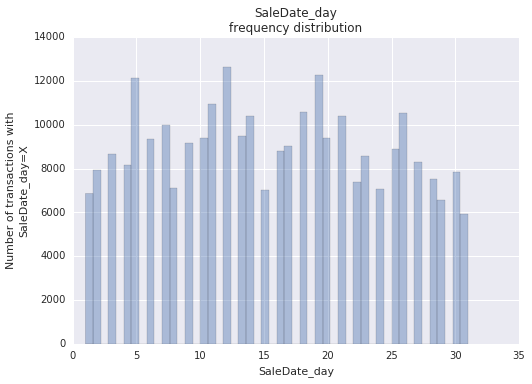

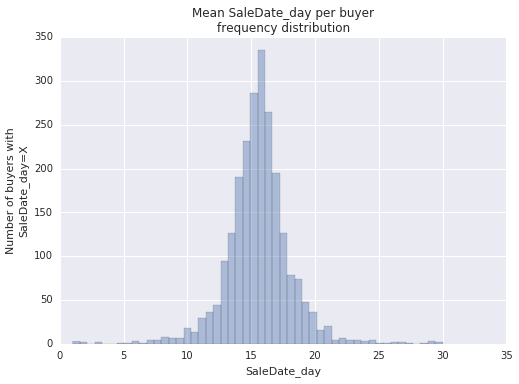

################################################################################
Feature: SaleDate_decyear


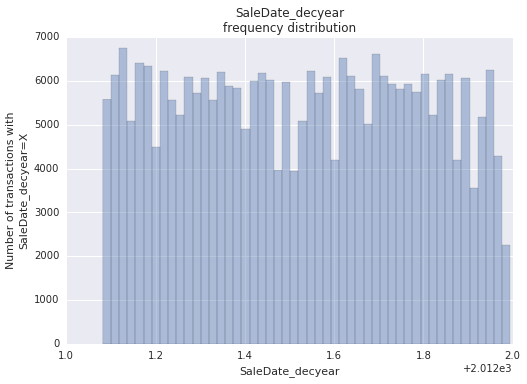

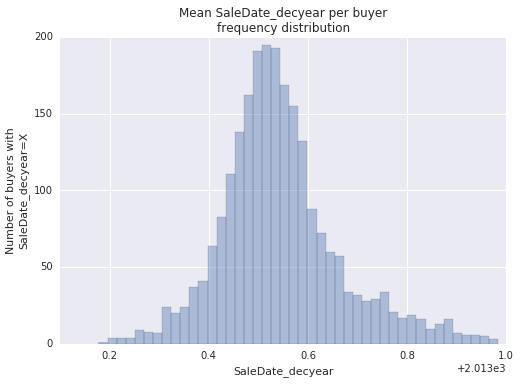

################################################################################
Feature: BuyerID_numTransactions


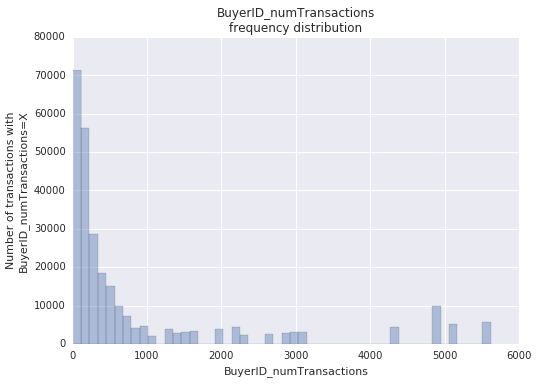

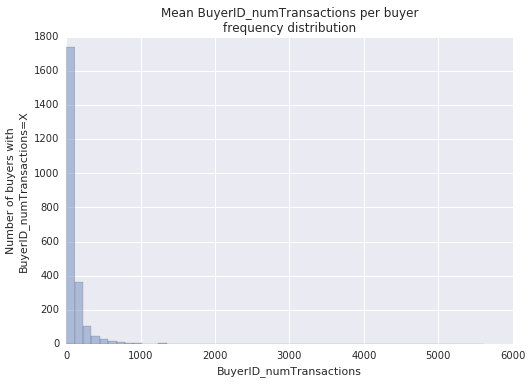

################################################################################
Feature: BuyerID_numDSEligible1


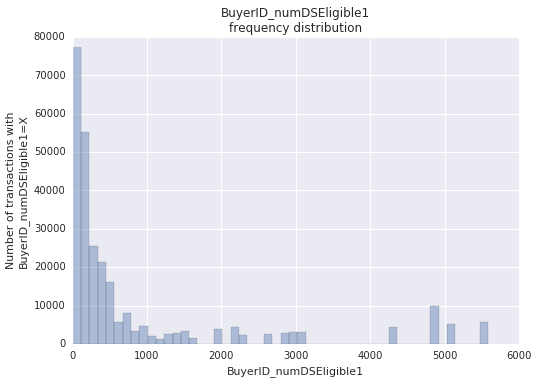

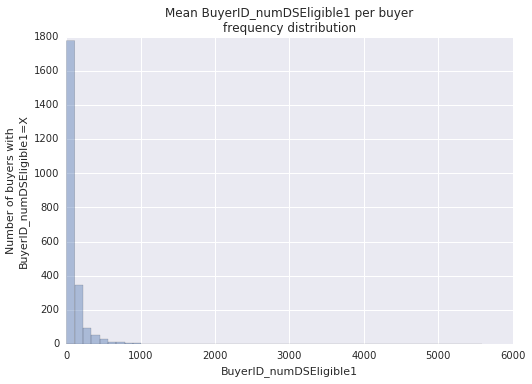

################################################################################
Feature: BuyerID_fracDSEligible1DivTransactions


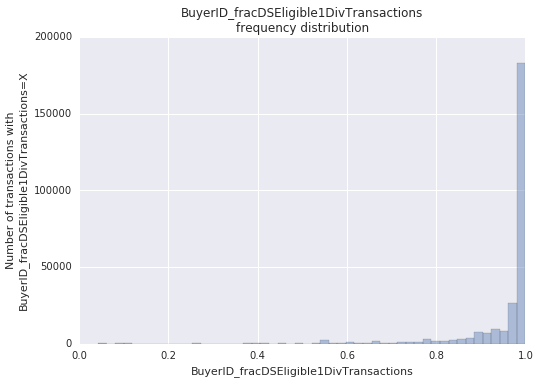

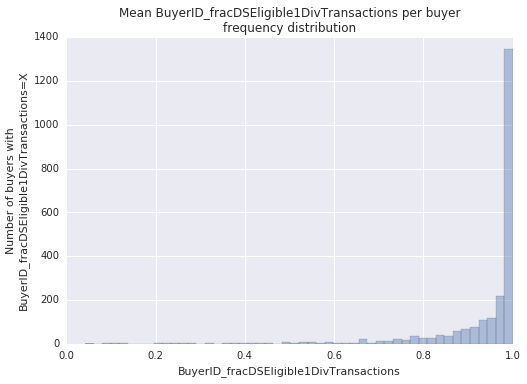

################################################################################
Feature: BuyerID_numReturnedNotNull


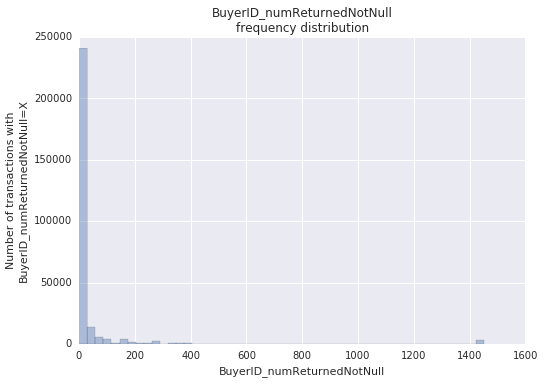

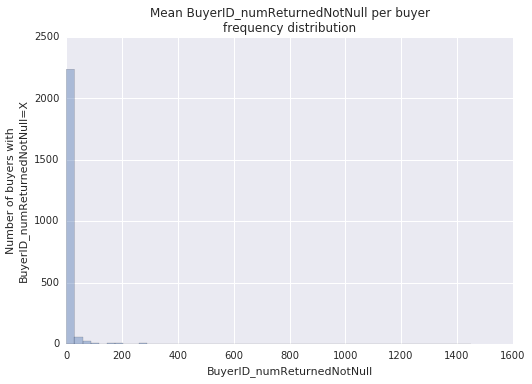

################################################################################
Feature: BuyerID_fracReturnedNotNullDivDSEligible1


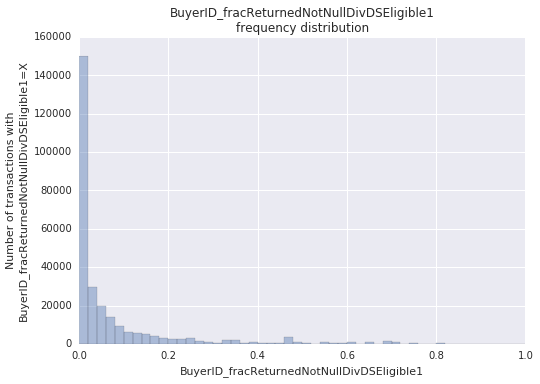

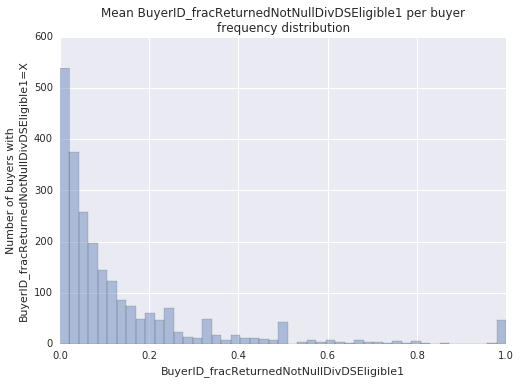

################################################################################
Feature: BuyerID_numReturned1


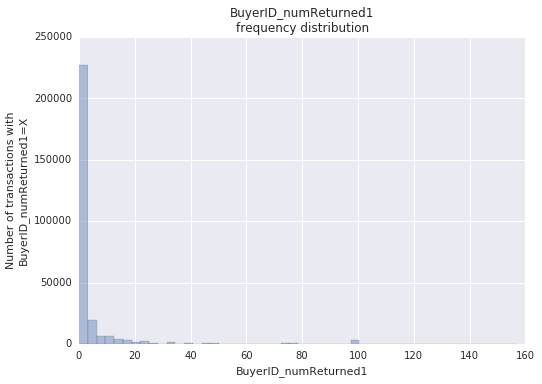

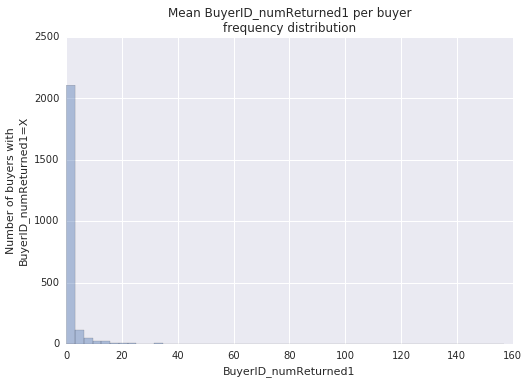

################################################################################
Feature: BuyerID_fracReturned1DivReturnedNotNull


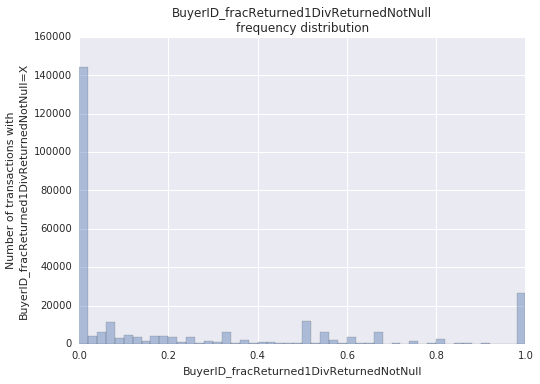

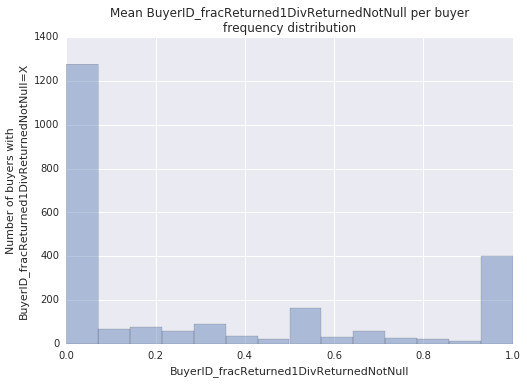

################################################################################
Feature: BuyerID_numReturnedasm1


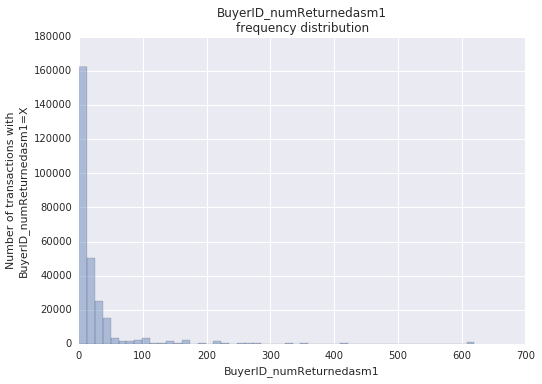

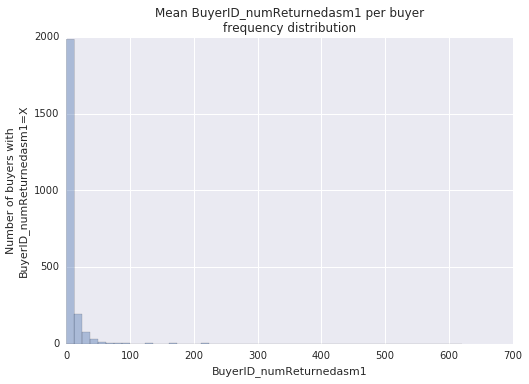

################################################################################
Feature: BuyerID_fracReturnedasm1DivTransactions


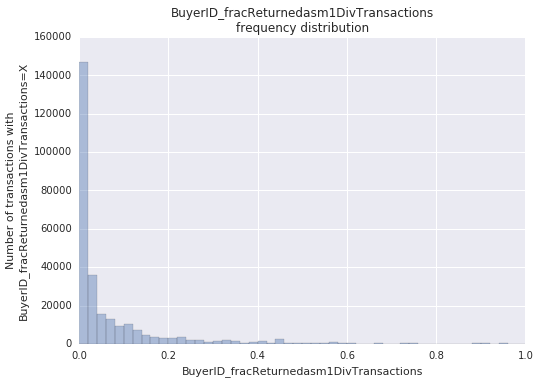

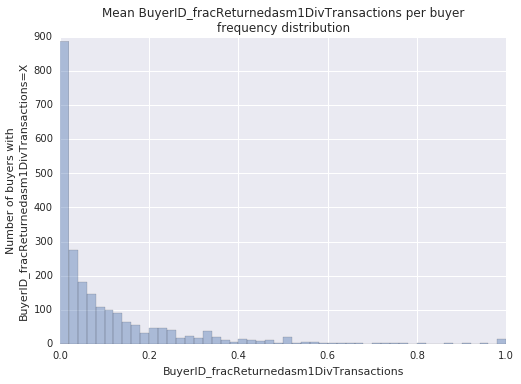

################################################################################
Feature: SellerID_numTransactions


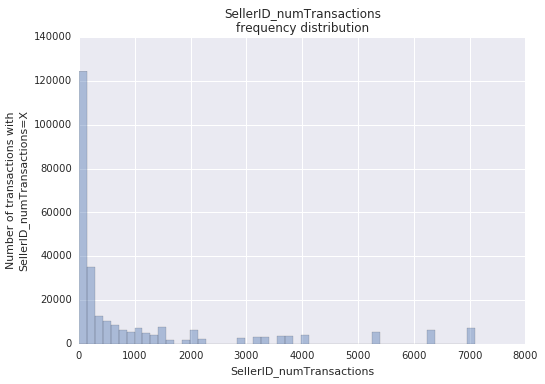

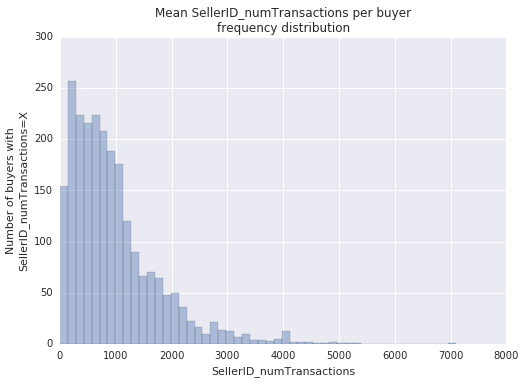

################################################################################
Feature: SellerID_numDSEligible1


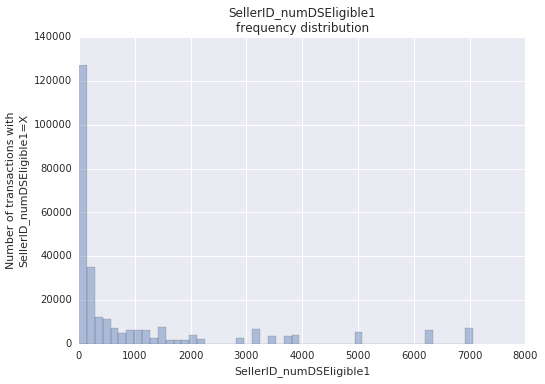

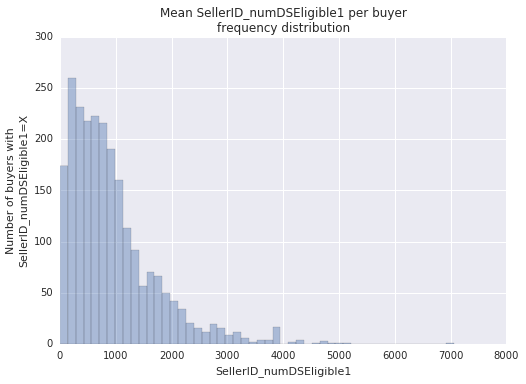

################################################################################
Feature: SellerID_fracDSEligible1DivTransactions


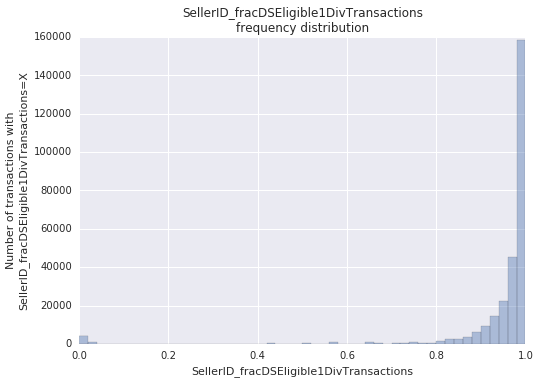

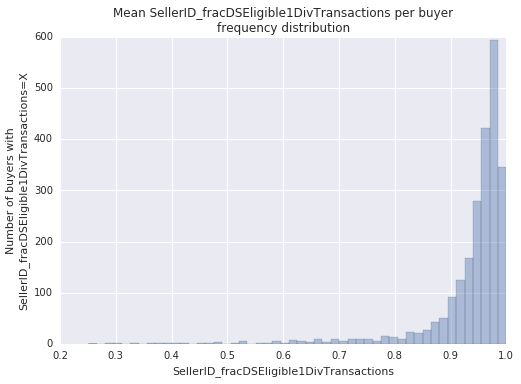

################################################################################
Feature: SellerID_numReturnedNotNull


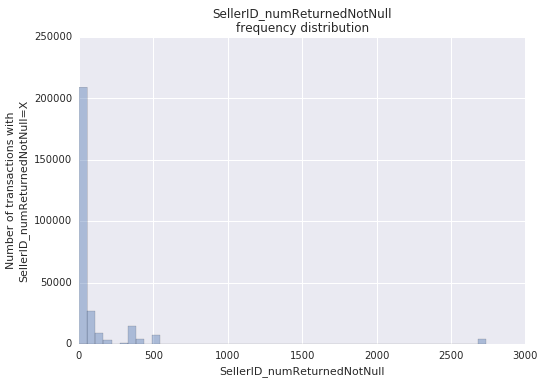

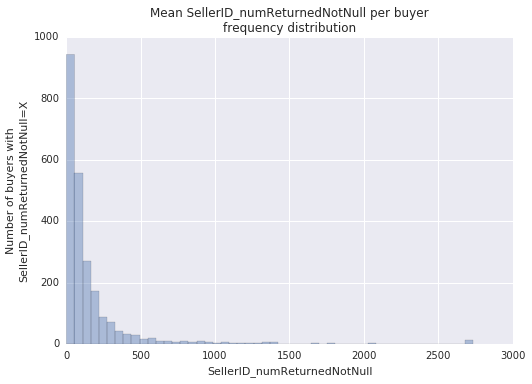

################################################################################
Feature: SellerID_fracReturnedNotNullDivDSEligible1


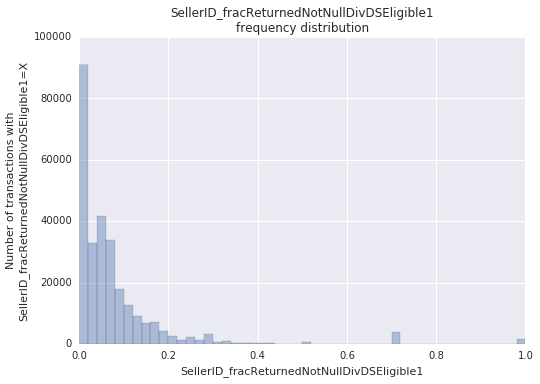

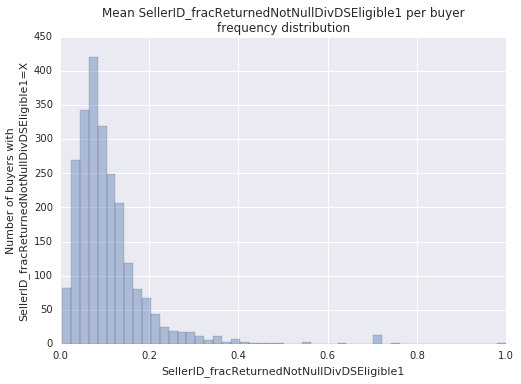

################################################################################
Feature: SellerID_numReturned1


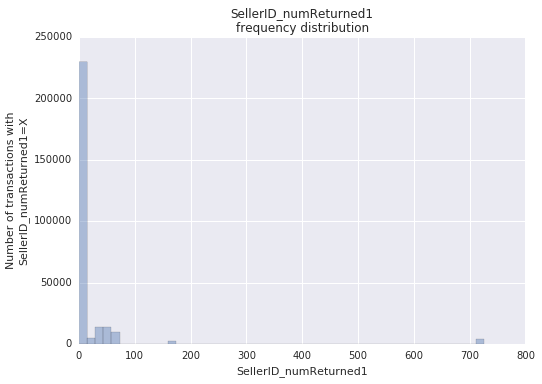

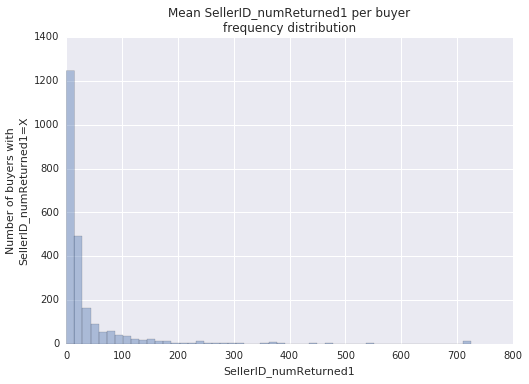

################################################################################
Feature: SellerID_fracReturned1DivReturnedNotNull


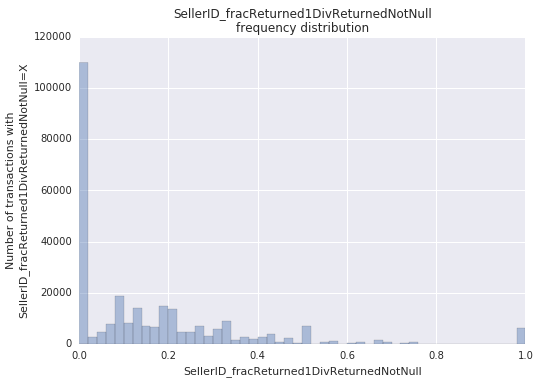

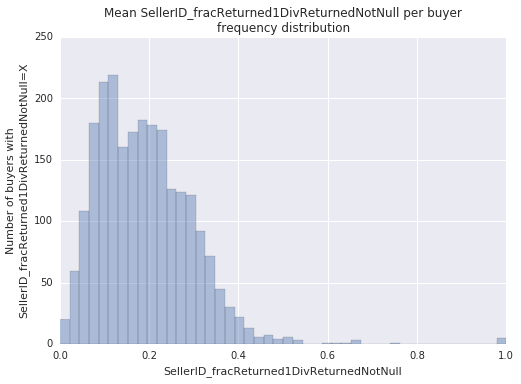

################################################################################
Feature: SellerID_numReturnedasm1


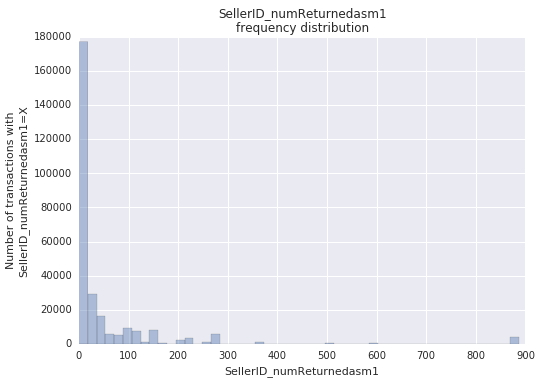

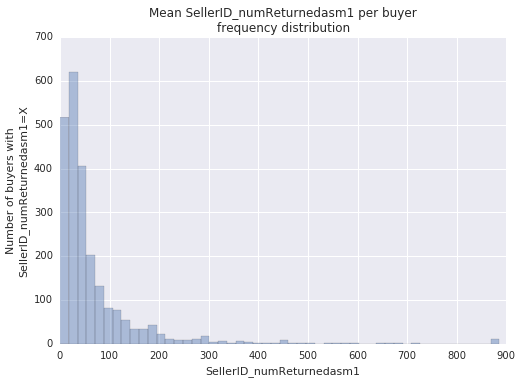

################################################################################
Feature: SellerID_fracReturnedasm1DivTransactions


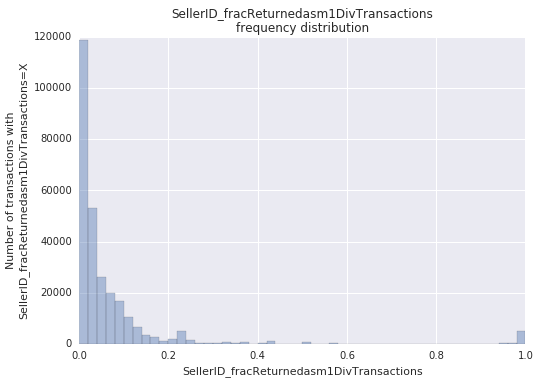

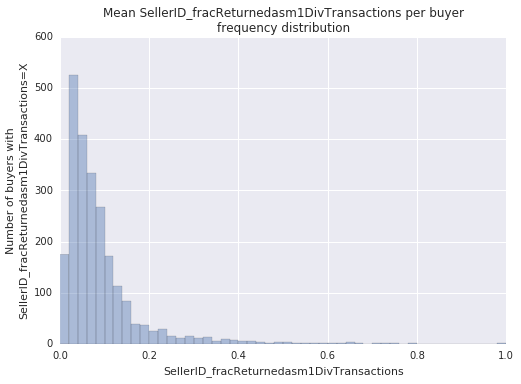

################################################################################
Feature: VIN_numTransactions


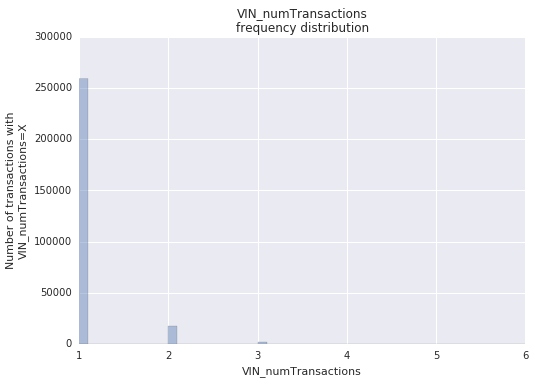

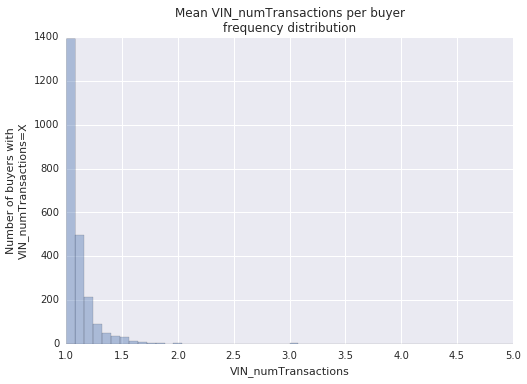

################################################################################
Feature: VIN_numDSEligible1


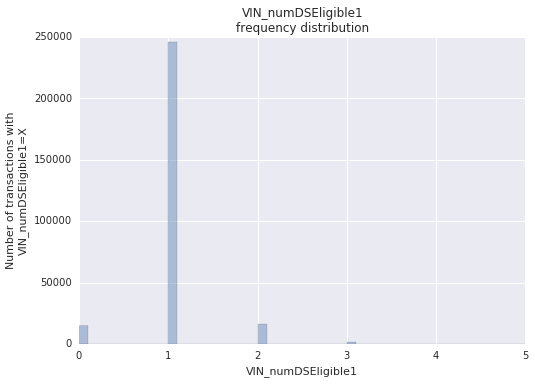

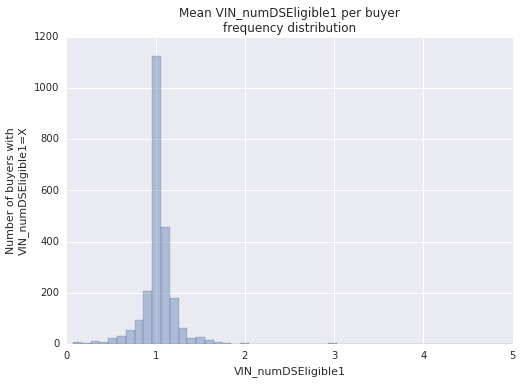

################################################################################
Feature: VIN_fracDSEligible1DivTransactions


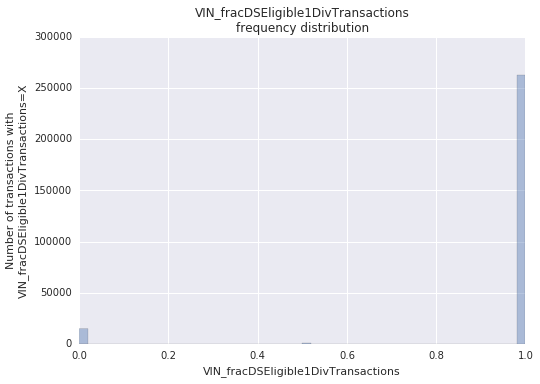

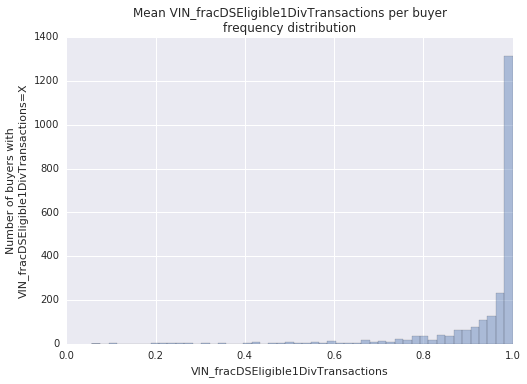

################################################################################
Feature: VIN_numReturnedNotNull


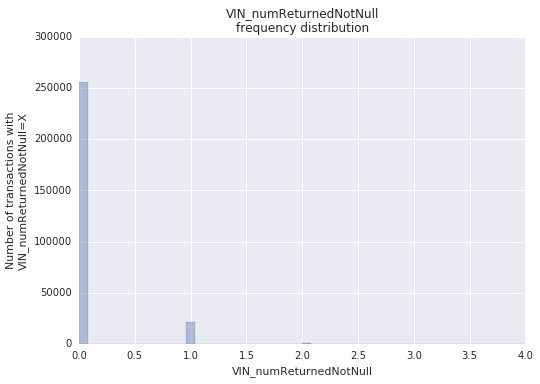

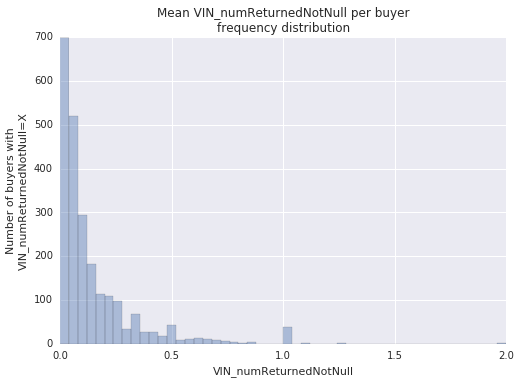

################################################################################
Feature: VIN_fracReturnedNotNullDivDSEligible1


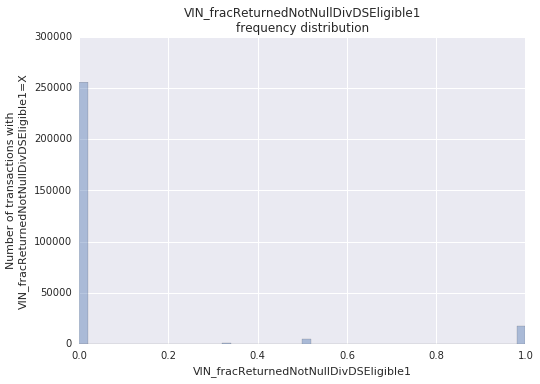

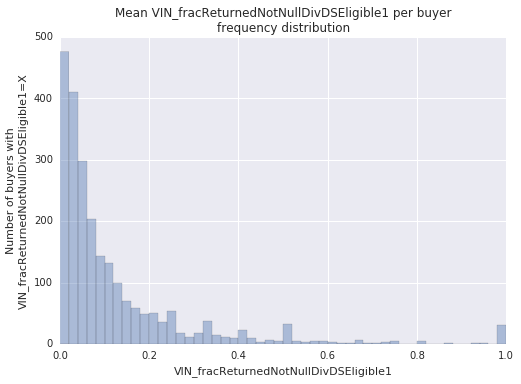

################################################################################
Feature: VIN_numReturned1


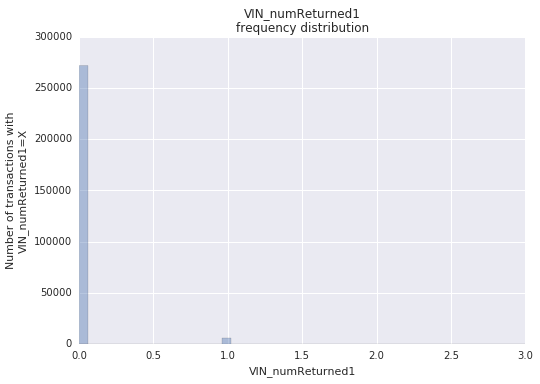

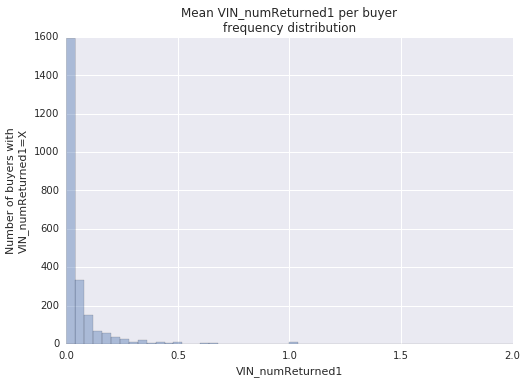

################################################################################
Feature: VIN_fracReturned1DivReturnedNotNull


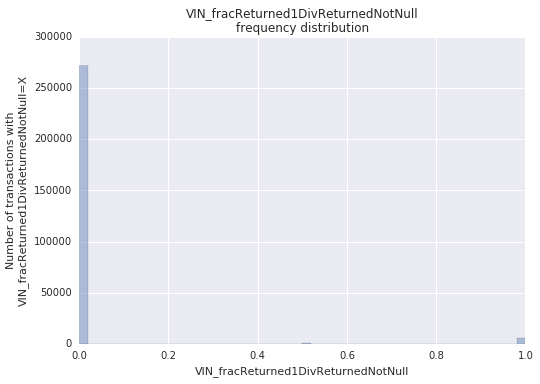

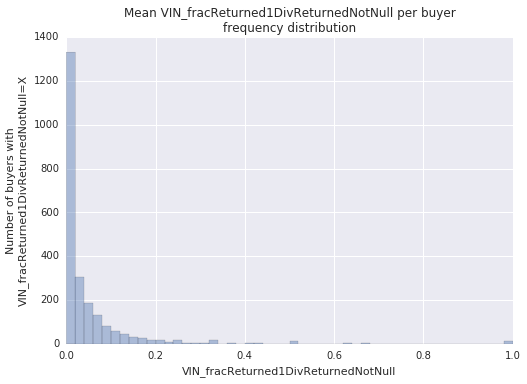

################################################################################
Feature: VIN_numReturnedasm1


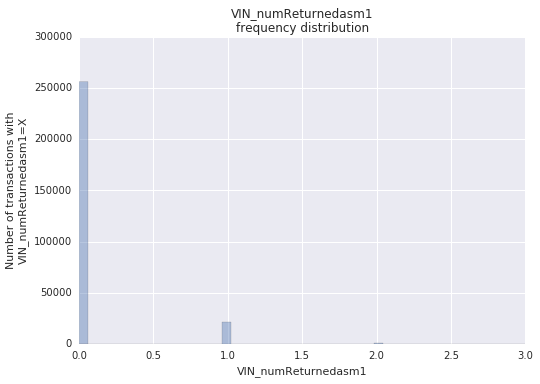

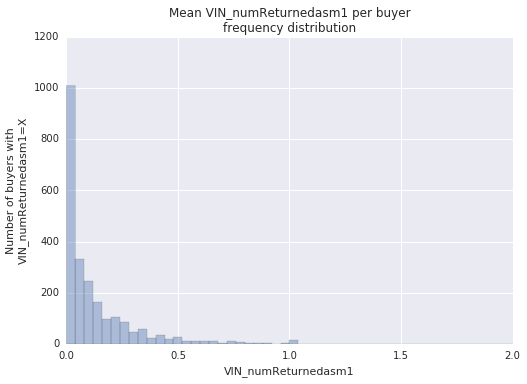

################################################################################
Feature: VIN_fracReturnedasm1DivTransactions


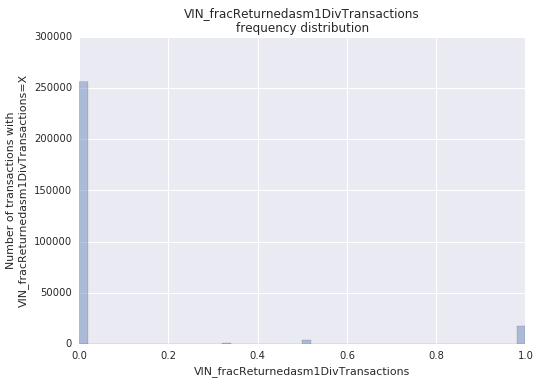

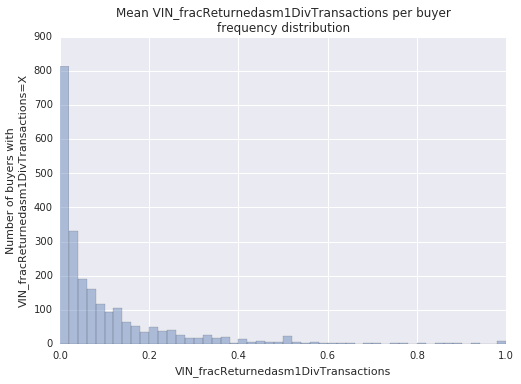

################################################################################
Feature: SellingLocation_numTransactions


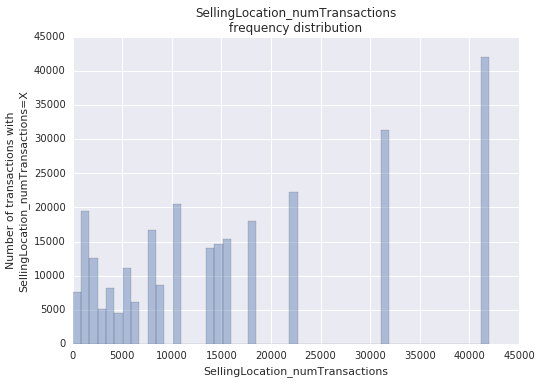

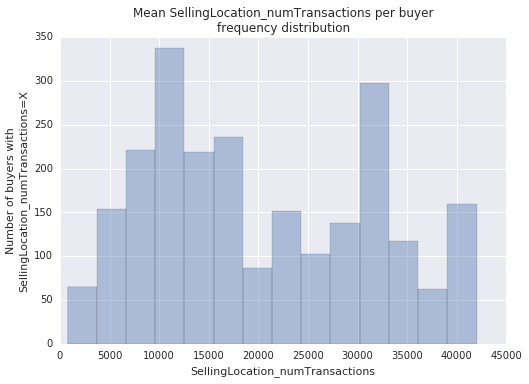

################################################################################
Feature: SellingLocation_numDSEligible1


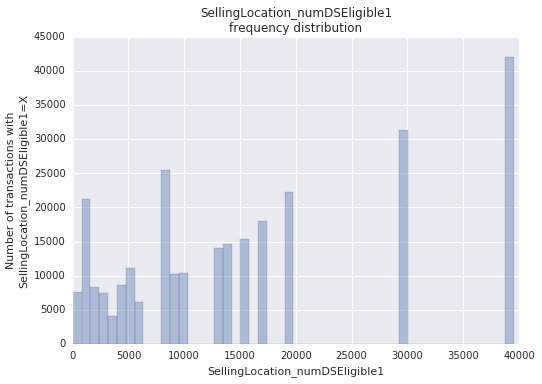

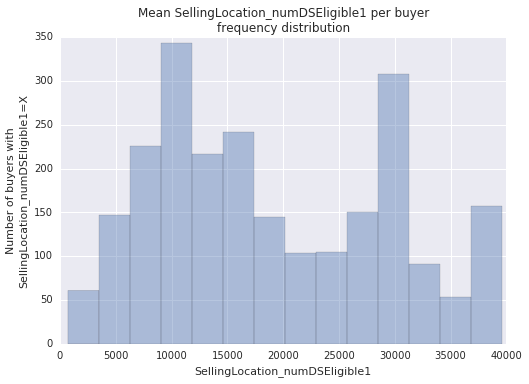

################################################################################
Feature: SellingLocation_fracDSEligible1DivTransactions


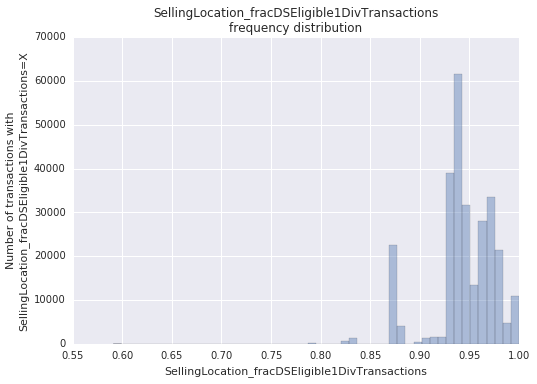

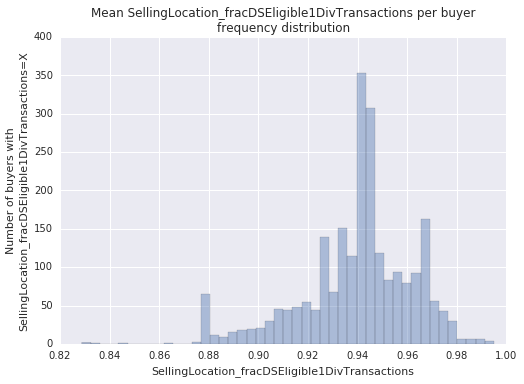

################################################################################
Feature: SellingLocation_numReturnedNotNull


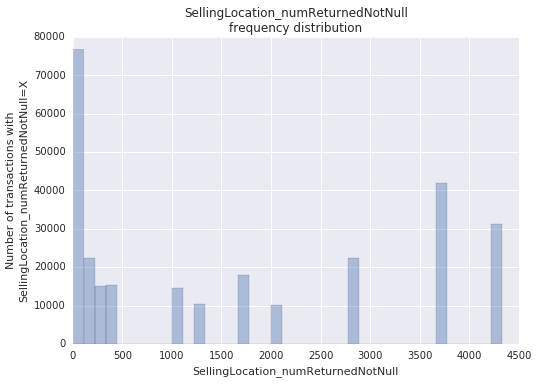

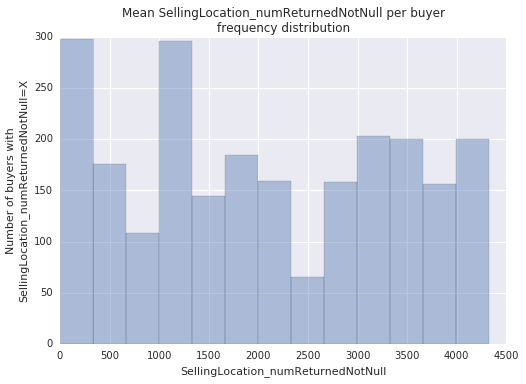

################################################################################
Feature: SellingLocation_fracReturnedNotNullDivDSEligible1


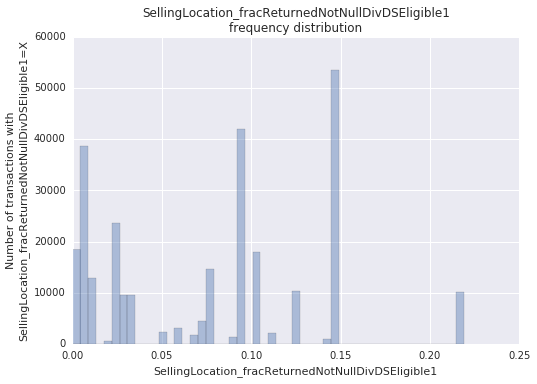

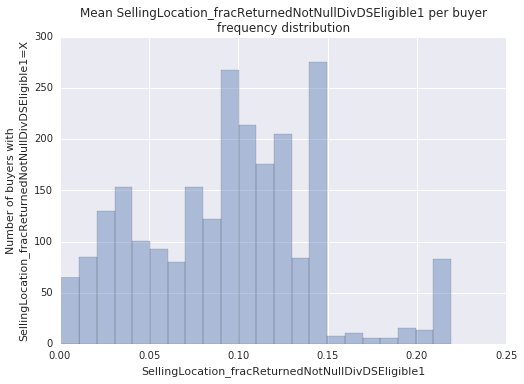

################################################################################
Feature: SellingLocation_numReturned1


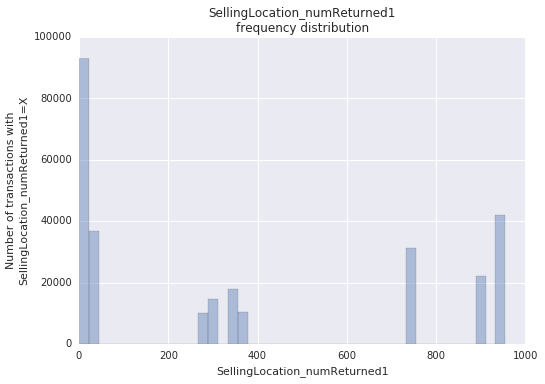

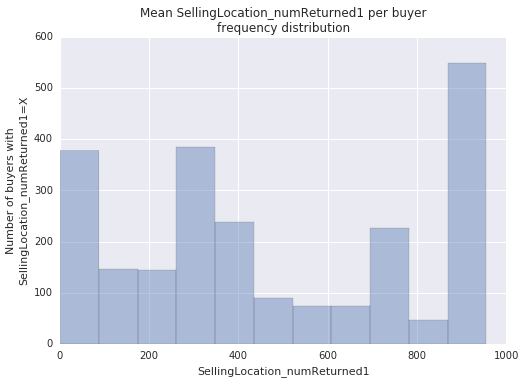

################################################################################
Feature: SellingLocation_fracReturned1DivReturnedNotNull


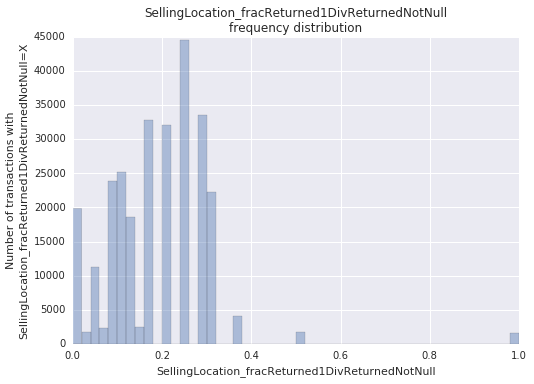

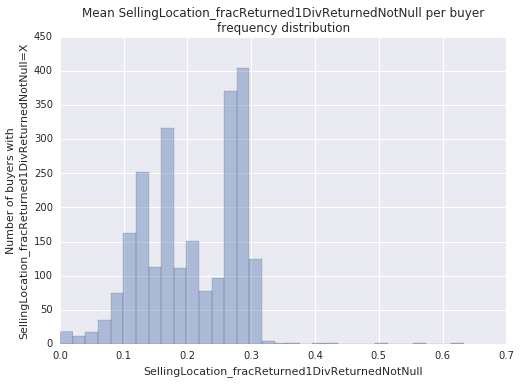

################################################################################
Feature: SellingLocation_numReturnedasm1


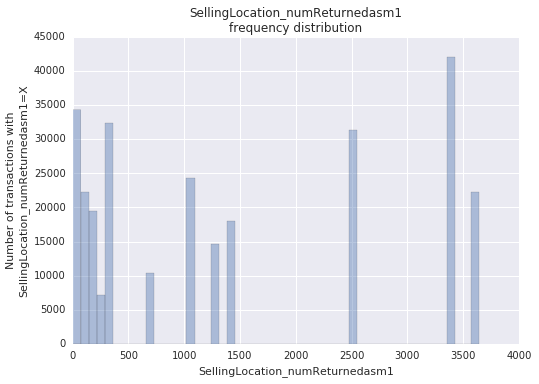

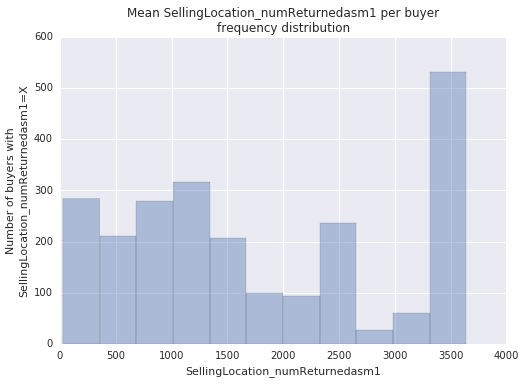

################################################################################
Feature: SellingLocation_fracReturnedasm1DivTransactions


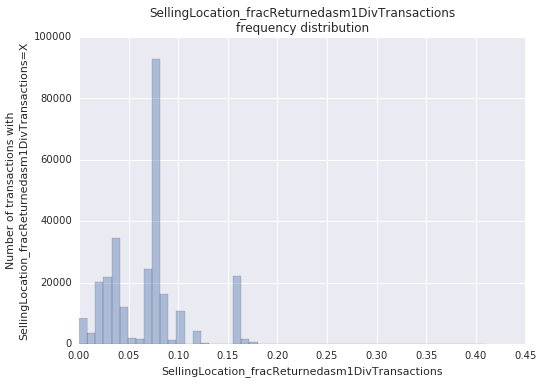

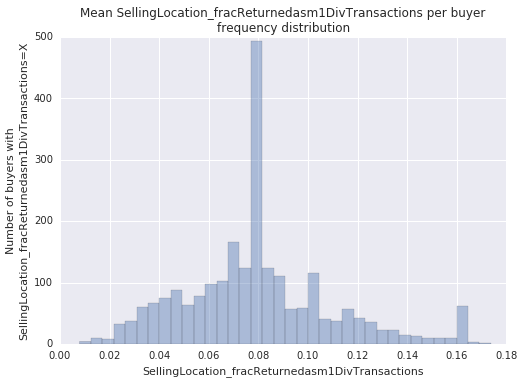

################################################################################
Feature: CarMake_numTransactions


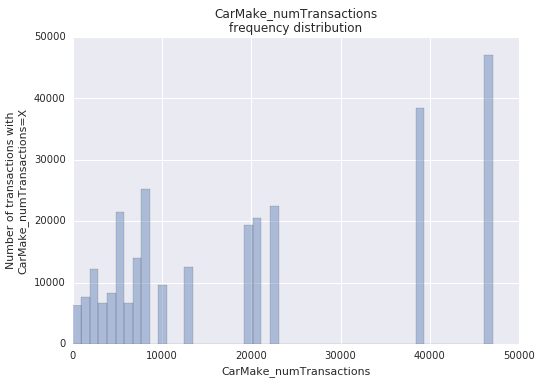

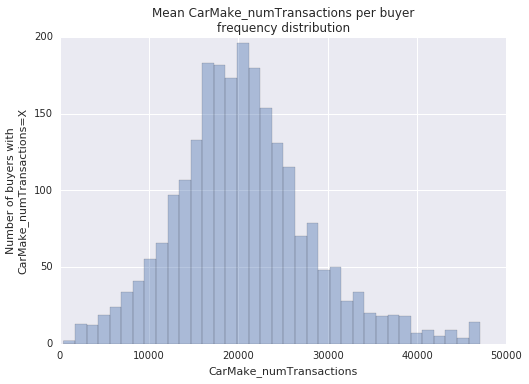

################################################################################
Feature: CarMake_numDSEligible1


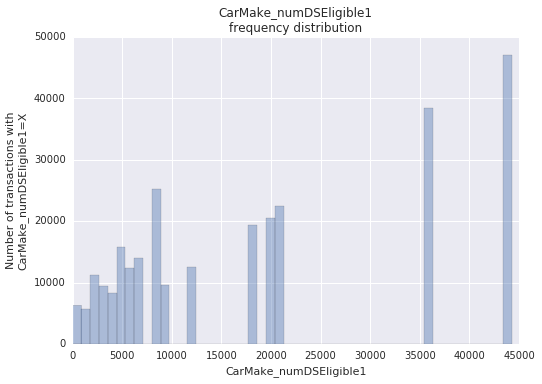

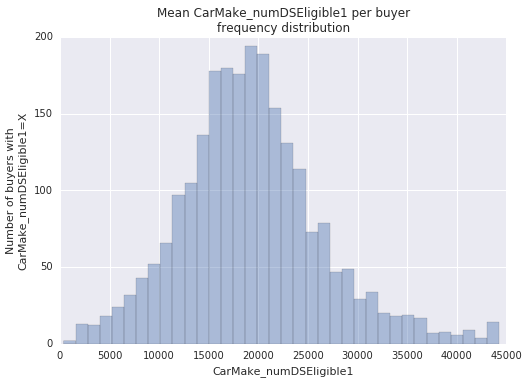

################################################################################
Feature: CarMake_fracDSEligible1DivTransactions


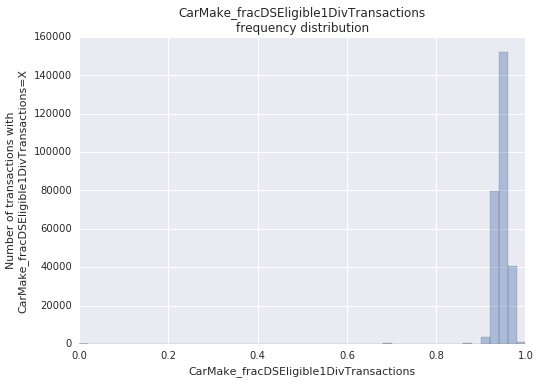

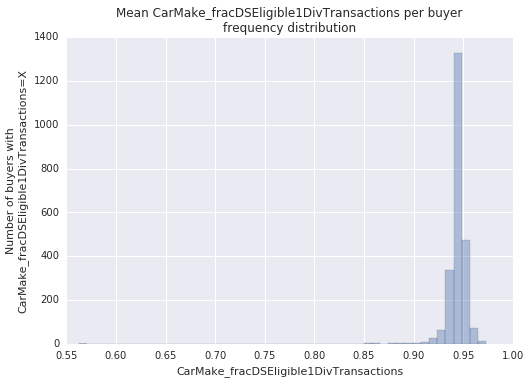

################################################################################
Feature: CarMake_numReturnedNotNull


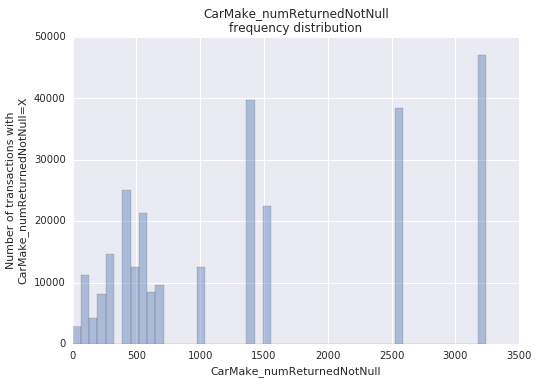

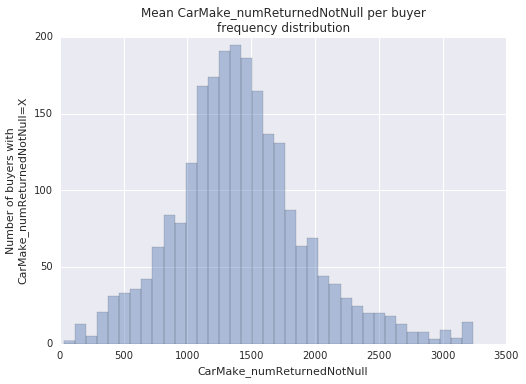

################################################################################
Feature: CarMake_fracReturnedNotNullDivDSEligible1


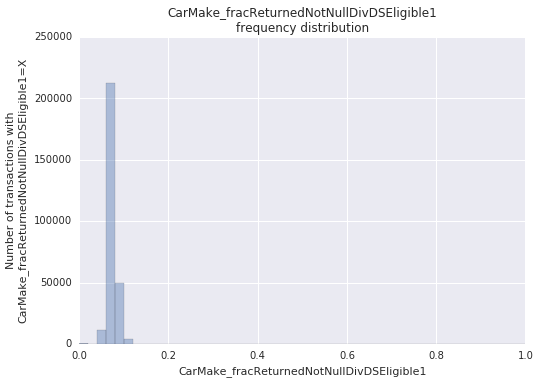

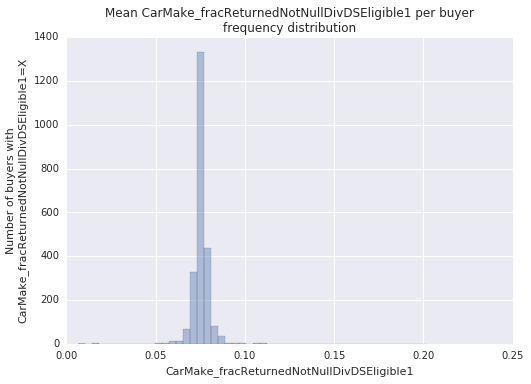

################################################################################
Feature: CarMake_numReturned1


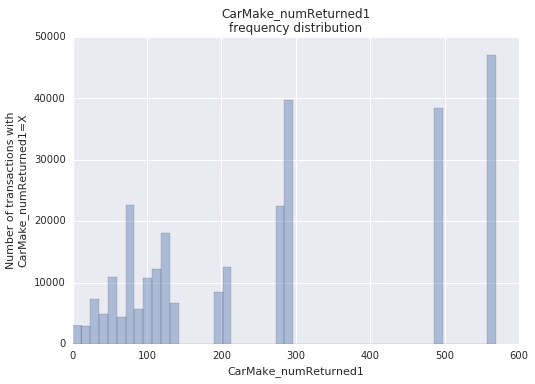

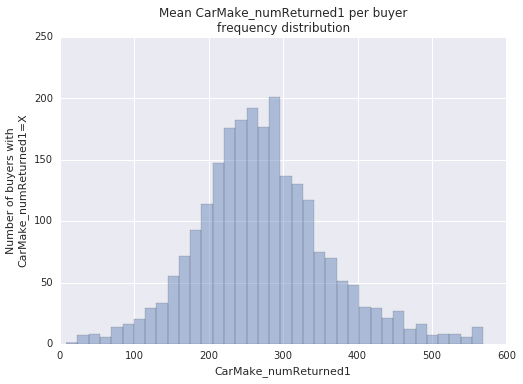

################################################################################
Feature: CarMake_fracReturned1DivReturnedNotNull


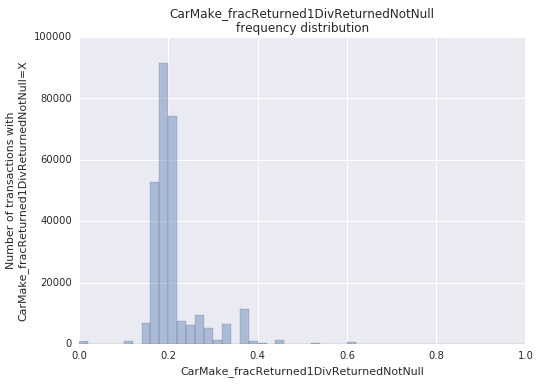

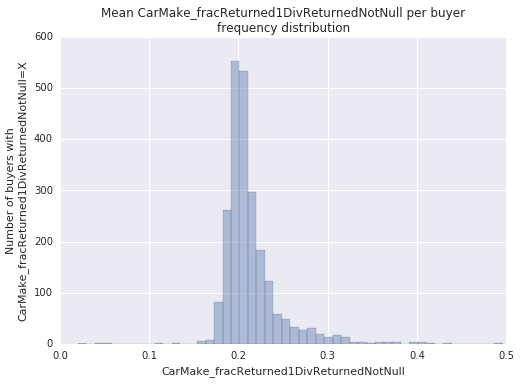

################################################################################
Feature: CarMake_numReturnedasm1


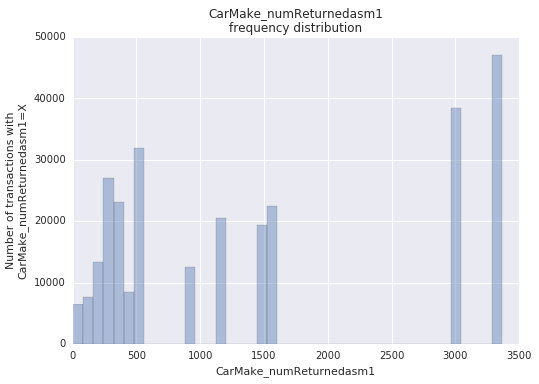

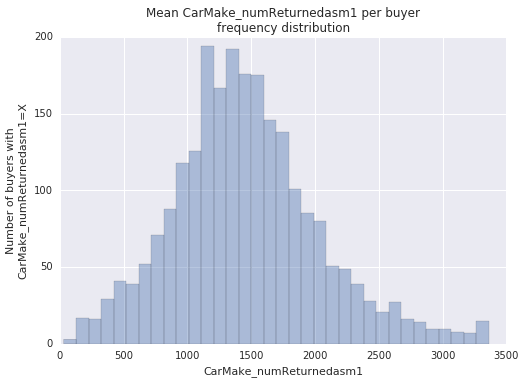

################################################################################
Feature: CarMake_fracReturnedasm1DivTransactions


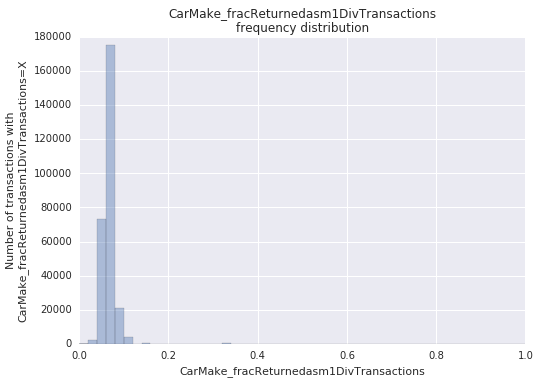

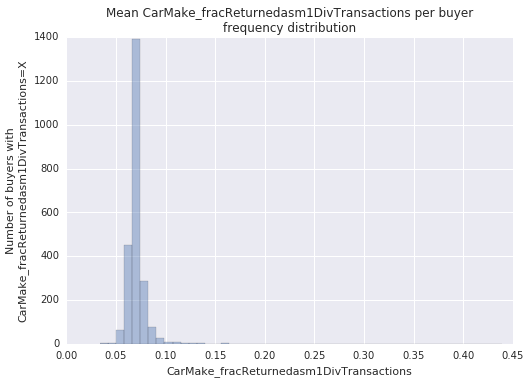

################################################################################
Feature: JDPowersCat_numTransactions


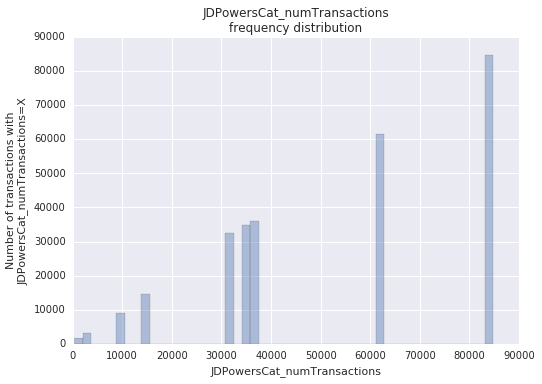

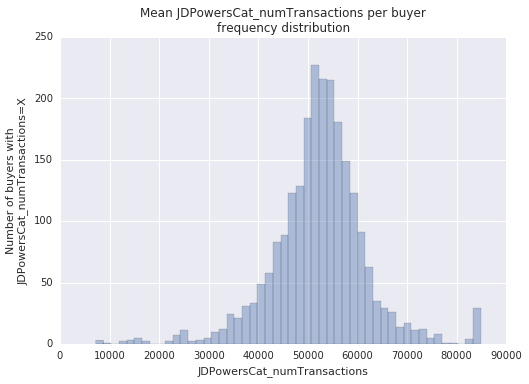

################################################################################
Feature: JDPowersCat_numDSEligible1


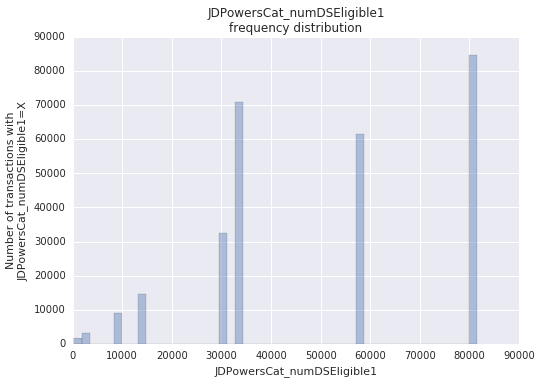

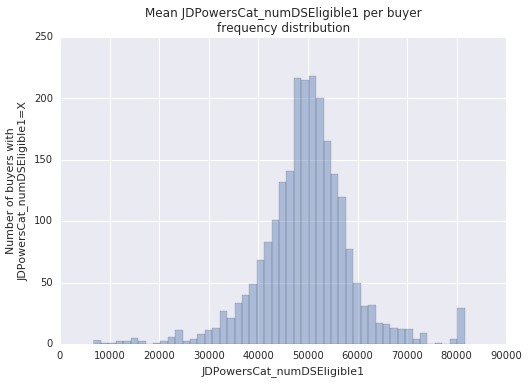

################################################################################
Feature: JDPowersCat_fracDSEligible1DivTransactions


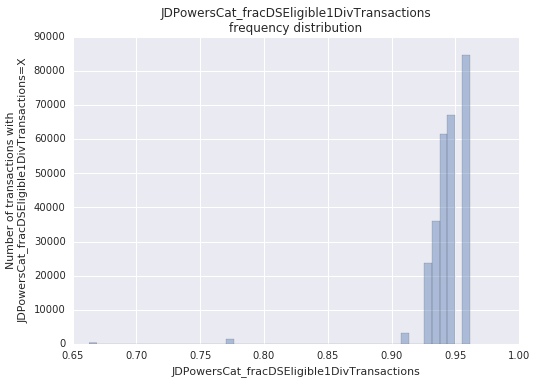

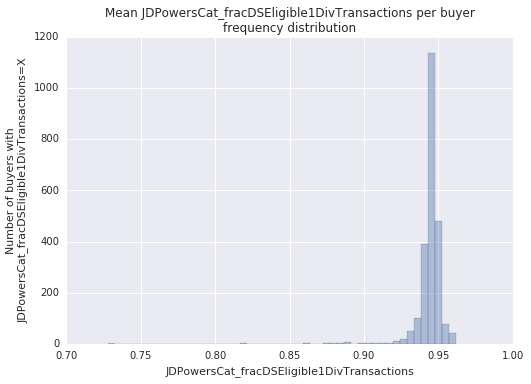

################################################################################
Feature: JDPowersCat_numReturnedNotNull


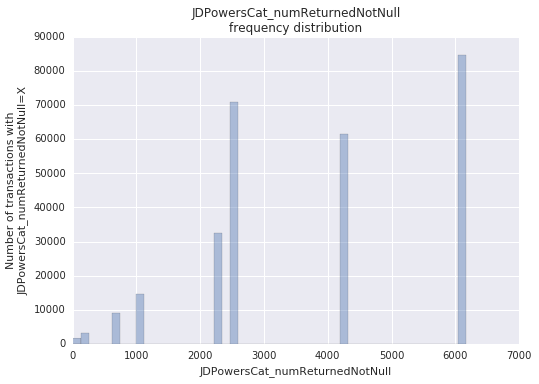

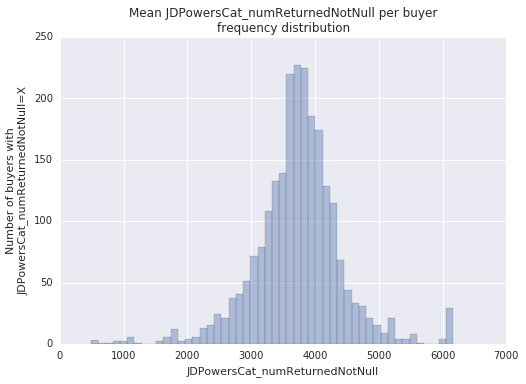

################################################################################
Feature: JDPowersCat_fracReturnedNotNullDivDSEligible1


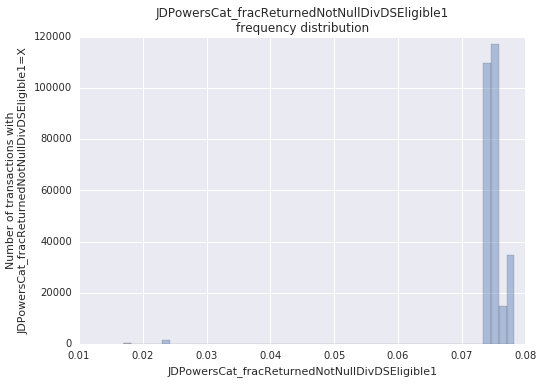

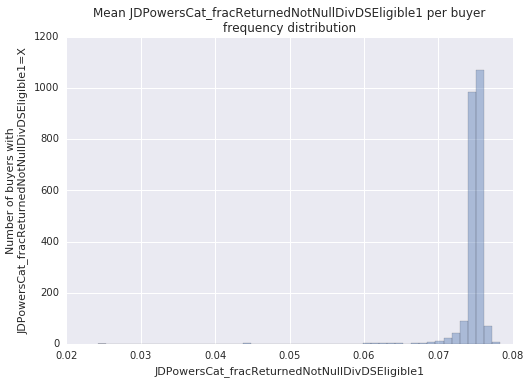

################################################################################
Feature: JDPowersCat_numReturned1


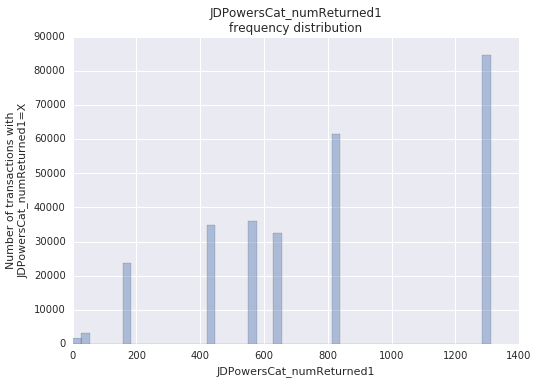

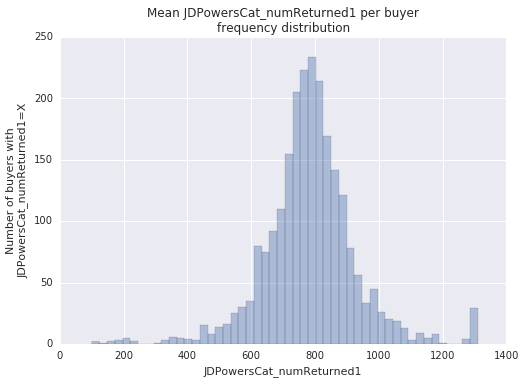

################################################################################
Feature: JDPowersCat_fracReturned1DivReturnedNotNull


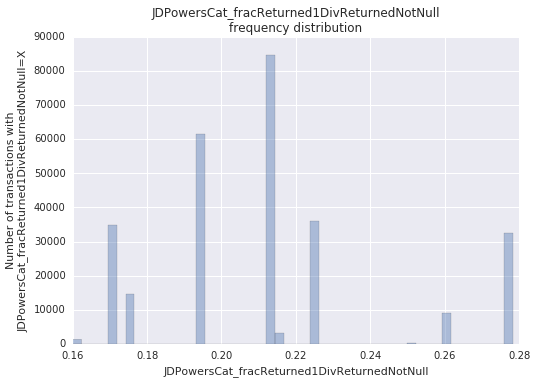

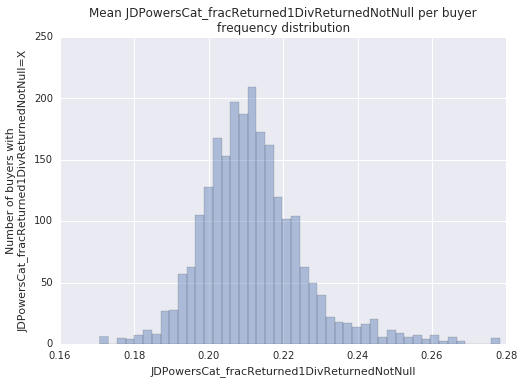

################################################################################
Feature: JDPowersCat_numReturnedasm1


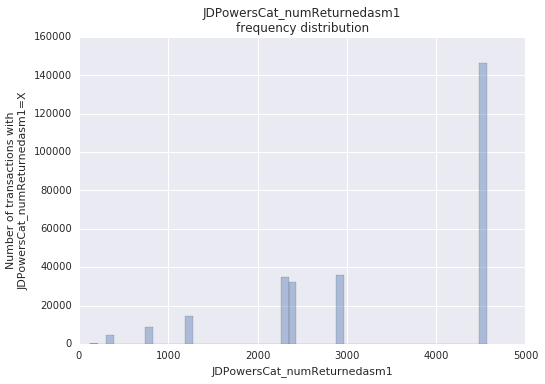

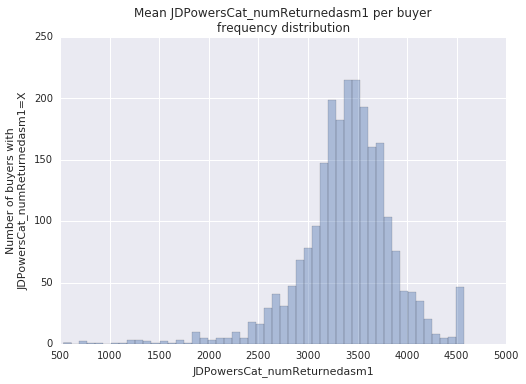

################################################################################
Feature: JDPowersCat_fracReturnedasm1DivTransactions


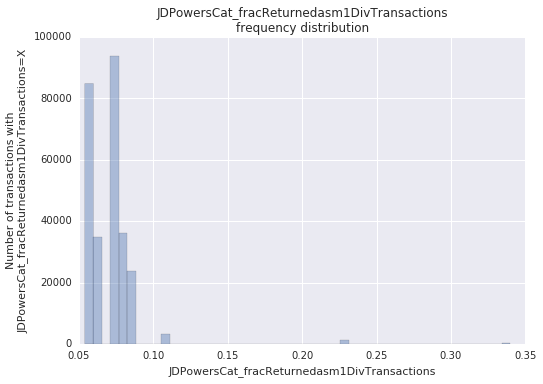

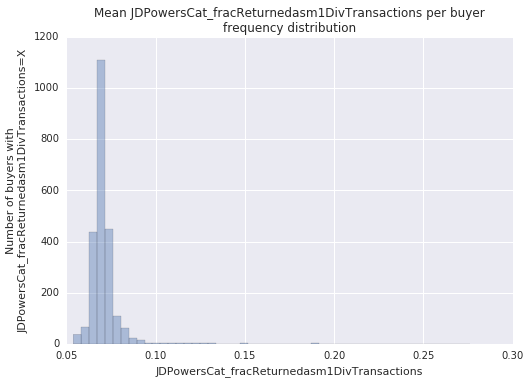

In [131]:
# Plot frequency distributions.
for ftr in ftrs:
    print('#'*80)
    print('Feature: {ftr}'.format(ftr=ftr))
    # ...by transaction
    sns.distplot(df[ftr].values, hist=True, kde=False, norm_hist=False)
    plt.title('{ftr}\nfrequency distribution'.format(ftr=ftr))
    plt.xlabel(ftr)
    plt.ylabel('Number of transactions with\n{ftr}=X'.format(ftr=ftr))
    plt.show()
    # ...by buyer
    sns.distplot(df[['BuyerID', ftr]].groupby(by='BuyerID').mean(), hist=True, kde=False, norm_hist=False)
    plt.title('Mean {ftr} per buyer\nfrequency distribution'.format(ftr=ftr))
    plt.xlabel(ftr)
    plt.ylabel('Number of buyers with\n{ftr}=X'.format(ftr=ftr))
    plt.show()

## Heuristic

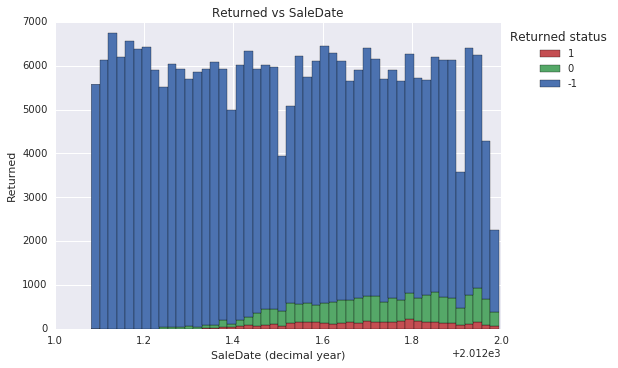

In [140]:
# Describe heuristic to identify bad dealers.

# Plot timeseries histogram of Returned vs SalesDate.
df_plot = df[['SaleDate_decyear', 'Returned']].copy()
itemized_counts = {
    ret: collections.Counter(grp['SaleDate_decyear'])
    for (ret, grp) in df_plot.groupby(by='Returned')}
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts.items(), key=lambda tup: tup[0], reverse=True))
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
colors = sns.color_palette(n_colors=len(keys))[::-1]
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors)
plt.title('Returned vs SaleDate')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned')
plt.legend(title='Returned status', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
del df_plot

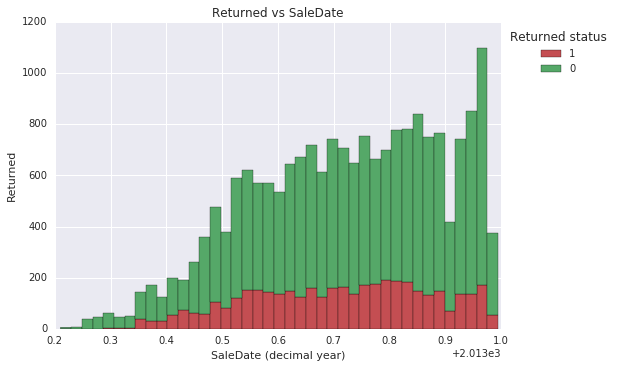

In [142]:
# Plot timeseries histogram of Returned (0,1) vs SalesDate.
df_plot = df.loc[df['Returned']!=-1, ['SaleDate_decyear', 'Returned']].copy()
itemized_counts = {
    ret: collections.Counter(grp['SaleDate_decyear'])
    for (ret, grp) in df_plot.groupby(by='Returned')}
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts.items(), key=lambda tup: tup[0], reverse=True))
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors[:2])
plt.title('Returned vs SaleDate')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned')
plt.legend(title='Returned status', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
del df_plot

In [171]:
# # ARCHIVED: Use return rate as heuristic rather than return count.
# # Plot timeseries histogram of Returned (1) vs SalesDate by BuyerID.
# df_plot = df.loc[df['Returned']==1, ['SaleDate_decyear', 'BuyerID']].copy()
# top = [tup[0] for tup in collections.Counter(df_plot['BuyerID']).most_common(n=20)]
# itemized_counts_all = {
#     buy: collections.Counter(grp['SaleDate_decyear'])
#     for (buy, grp) in df_plot.groupby(by='BuyerID')}
# itemized_counts_top = {'other': collections.Counter()}
# for (buyerid, counts) in itemized_counts_all.items():
#     if buyerid in top:
#         itemized_counts_top[buyerid] = counts
#     else:
#         itemized_counts_top['other'].update(counts)
# itemized_counts = collections.OrderedDict(
#     sorted(itemized_counts_top.items(), key=lambda tup: sum(tup[1].values()), reverse=True))
# itemized_counts.move_to_end('other')
# keys = itemized_counts.keys()
# bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
# colors = sns.light_palette(sns.color_palette()[2], n_colors=len(keys))
# plt.hist(
#     [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
#     bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors)
# plt.title('Returned vs SaleDate by BuyerID')
# plt.xlabel('SaleDate (decimal year)')
# plt.ylabel('Returned (status=1)')
# plt.legend(title='BuyerID', loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()
# del df_plot

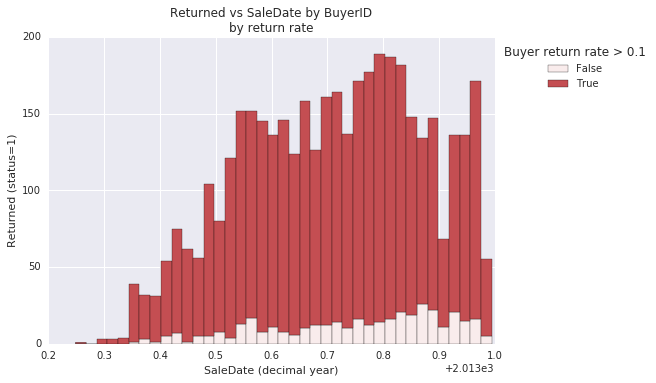

In [170]:
# Plot timeseries histogram of Returned (1) vs SalesDate
# by BuyerID for BuyerIDs with return rate > 0.1.
buyer_retrate = 'BuyerID_fracReturned1DivReturnedNotNull'
df_plot = df.loc[df['Returned']==1, ['SaleDate_decyear', 'BuyerID', buyer_retrate]].copy()
buyers_retrategt01 = df_plot.loc[df_plot[buyer_retrate] > 0.1, 'BuyerID'].unique()
buyer_retrate_gt01 = buyer_retrate+'_gt01'
df_plot[buyer_retrate_gt01] = df_plot[buyer_retrate] > 0.1
itemized_counts = {
    gt01: collections.Counter(grp['SaleDate_decyear'])
    for (gt01, grp) in df_plot.groupby(by=buyer_retrate_gt01)}
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts.items(), key=lambda tup: tup[0], reverse=False))
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
colors = sns.light_palette(sns.color_palette()[2], n_colors=len(keys))
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors)
plt.title('Returned vs SaleDate by BuyerID\nby return rate')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned (status=1)')
plt.legend(title='Buyer return rate > 0.1', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
del df_plot

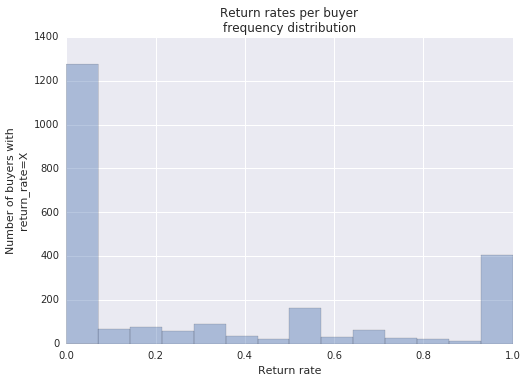

In [172]:
# Plot frequency distribution of return rates per BuyerID
ftr = buyer_retrate
sns.distplot(df[['BuyerID', ftr]].groupby(by='BuyerID').mean(), hist=True, kde=False, norm_hist=False)
plt.title('Return rates per buyer\nfrequency distribution')
plt.xlabel('Return rate')
plt.ylabel('Number of buyers with\nreturn_rate=X')
plt.show()

In [173]:
buyers_retrategt01

array(['351601', '351299', '351241', ..., '1279', '1187', '376'], dtype=object)

In [ ]:
# TODO
# Determine which features are categorical and plot.
# Features are considered "categorical" if
# num_unique_feature_values < min(num_unique_id_values, num_unique_target_values)
(df_ftrs, ds_trg) = (step.s2.dfs.df_features_model, step.s2.dfs.ds_target_model)
(nuniq_uid, nuniq_trg) = (len(df_ftrs['SERIALNO'].unique()), len(ds_trg.unique()))
nuniq_min = min(nuniq_uid, nuniq_trg)
(ftr_nuniq, nuniq_nftrs, cat_ftrs) = (dict(), collections.defaultdict(int), list())
for ftr in df_ftrs.columns:
    ftr_nuniq[ftr] = len(df_ftrs[ftr].unique())
for (ftr, nuniq) in ftr_nuniq.items():
    nuniq_nftrs[nuniq] += 1
    if 1 < nuniq < nuniq_min:
        cat_ftrs.append(ftr)
nuniq_nftrs = np.asarray(sorted(nuniq_nftrs.items()))
tfmask = np.logical_and(1 < nuniq_nftrs[:, 0], nuniq_nftrs[:, 0] < nuniq_min)
nuniq_nftrs_cat = nuniq_nftrs[tfmask]
if not np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs):
    raise AssertionError(
        ("Program error. The tallies of categorical features do not match.\n" +
         "Required: np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=np.sum(nuniq_nftrs_cat[:, 1]), rhs=len(cat_ftrs)))
print(
    ("Features are considered 'categorical' if num_unique_feature_values\n" +
     "    < min(num_unique_id_values ({uid}), num_unique_target_values ({trg}))\n" +
     "    = min({nuid}, {ntrg}) = {nmin}\n" +
     "Percent of features that are categorical: {frac:.1%}").format(
        uid='SERIALNO', trg=step.s0.dfs.ds_target_model.name,
        nuid=nuniq_uid, ntrg=nuniq_trg, nmin=nuniq_min,
        frac=len(cat_ftrs)/len(df_ftrs.columns)))
plt.semilogx(
    nuniq_nftrs[:, 0], nuniq_nftrs[:, 1], marker='.', linestyle='-',
    color=sns.color_palette()[0], label='features')
plt.semilogx(
    nuniq_nftrs_cat[:, 0], nuniq_nftrs_cat[:, 1], marker='o', linestyle='',
    color=sns.color_palette('dark')[0], label='categorical features')
plt.axvline(
    x=len(step.s2.dfs.ds_target_model.unique()),
    color=sns.color_palette()[1], label=step.s2.dfs.ds_target_model.name)
plt.axvline(
    x=len(step.s2.dfs.df_features_model['SERIALNO'].unique()),
    color=sns.color_palette()[2], label='SERIALNO')
plt.title("Number of feature vs number of unique values per feature")
plt.xlabel("Number of unique values per feature")
plt.ylabel("Number of features")
plt.legend(loc='upper center')
plt.show()